In [1]:
import pandas as pd
import numpy as np

# Melbourne Housing Market

Датасет представляет из себя цены на квартире в мельбурне. Данные взять с kaggle (https://www.kaggle.com/anthonypino/melbourne-housing-market/data).
Я поставил такую цель - научиться предсказывать цену по параметрам недвижимости.
Это может быть актуально при создании объявлений о покупке\аредны жилья. Вряд ли кто-то захочет сильно переплачивать или недополучать за недвижимость, если в 100 метрах рядом есть такое же.
В качестве целевого признака будет использовать Price

In [2]:
df_raw = pd.read_csv('../data/Melbourne_housing_FULL.csv')
df_raw["Date"] = pd.to_datetime(df_raw["Date"])
df_raw.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,2016-03-09,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-04-02,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,2016-04-02,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-04-03,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null datetime64[ns]
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1), obj

Как видим, по целевому признаку есть пропуски. Уже есть цель их восстановить:) 
8 - категориальных 
13 - num признаков

Примерный перевод признаков

**Suburb**: Название пригорода

**Address**: Адресс

**Rooms**: Количество комнат

**Price**: Цена в долларах

**Method**: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

**Type**: br - bedroom(s); h - дом, коттедж, вила; u - блок домов, дуплекс; t - таун хаус; dev site - в процессе постройки; o res - other residential.

**SellerG**: Аген по недвижимости

**Date**: Дата продажи

**Distance**: Расстояние до CBD (Central Business District)

**Regionname**: Регион (West, North West, North, North east ...etc)

**Propertycount**: количество продающихся домов в данном пригороде.

**Bedroom2**: Scraped # of Bedrooms (from different source)

**Bathroom**: Количество ванных комнат

**Car**: Количество машиноместа

**Landsize**: Площадь участка

**BuildingArea**: Размер дома

**YearBuilt**: Год постройки

**CouncilArea**: Какой гос совет тут руководит

**Lattitude, Longtitude** - координаты	

In [4]:
## Уберем записи с пропущенным price
print(df_raw.shape)

df_missed = df_raw[df_raw['Price'].isnull()]
df = df_raw[df_raw['Price'].notnull()]

print(df_missed.shape, df.shape)

(34857, 21)
(7610, 21) (27247, 21)


In [5]:
df_p = df.drop('Price', axis=1)
y = df.Price.values

# Работа с исходными данными и визуацлизаця

In [6]:
import seaborn as sns
from scipy.stats import normaltest, shapiro, skewtest
import matplotlib.pyplot as plt

## Целевой признак

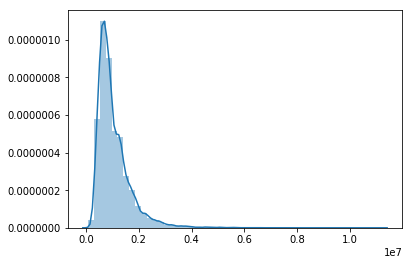

In [7]:
sns.distplot(y);

Как видим, у переменной большой хвост справа. Это вполне ожидаемо: любой каприз за ваши деньги. Такую велечину плохо прогнозировать. Попробуем её логорифмировать:

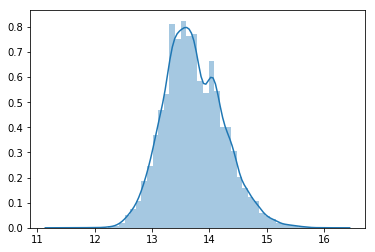

In [8]:
sns.distplot(np.log(y));

Уже больше похоже на нормальное распределение.

Протестируем на нормальность и скошенность:

In [9]:
k2, p = normaltest(np.log(y))
print('normaly:', k2, p)

k2, p = skewtest(np.log(y))
print('skewness:', k2, p)

## Тест на нормальность и скошенность не пройден

normaly: 510.09506838399636 1.714996655278188e-111
skewness: 22.04719538226543 1.0163007114804677e-107


Построим нормальное с таким же средним и стандартным отклонением

In [10]:
a = np.random.normal(np.mean(np.log(y)), np.std(np.log(y)), size=len(y))

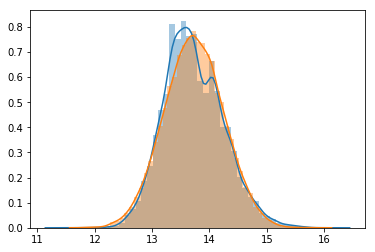

In [11]:
sns.distplot(np.log(y));
sns.distplot(a);

Распределения очень похожи. По всей видимости, целевая переменная не проходит тест из-за бимодальности. Резкий всплекс цен приходится на exp(14) ~ 1.2млн$. Возможно это как-то связано с местным законодатесльвом.


**Будем считать, что логорифмированные данные нормальны и не скошенны.**

# Взаимодействие признаков

### Корреляции

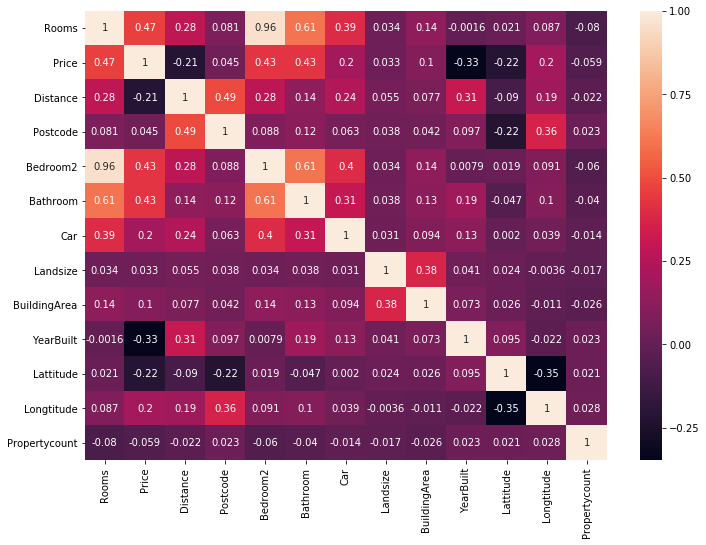

In [12]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.heatmap(df.corr(), annot=True, ax=ax);

**Выводы**:

Как видно, сильно скоррелированы Rooms и Bedroom2. Фактически это один и тот же признак, но второй с пропусками.

Так же с количеством комнат скоррелированы - количество ванных комнат, машиномест и цена. Это тоже интуитивно понятно - чем больше жильё, тем больше в нем комнат, ванных, машиномест и тем оно дороже.

Год постройки и дистанция "немного" скоррелированы. Это можно объяснить тем, что в центре уже нет мест для новых домов. И все новое строится далеко.

Чем старше дом - тем он дешевле.

### Попарное распределение

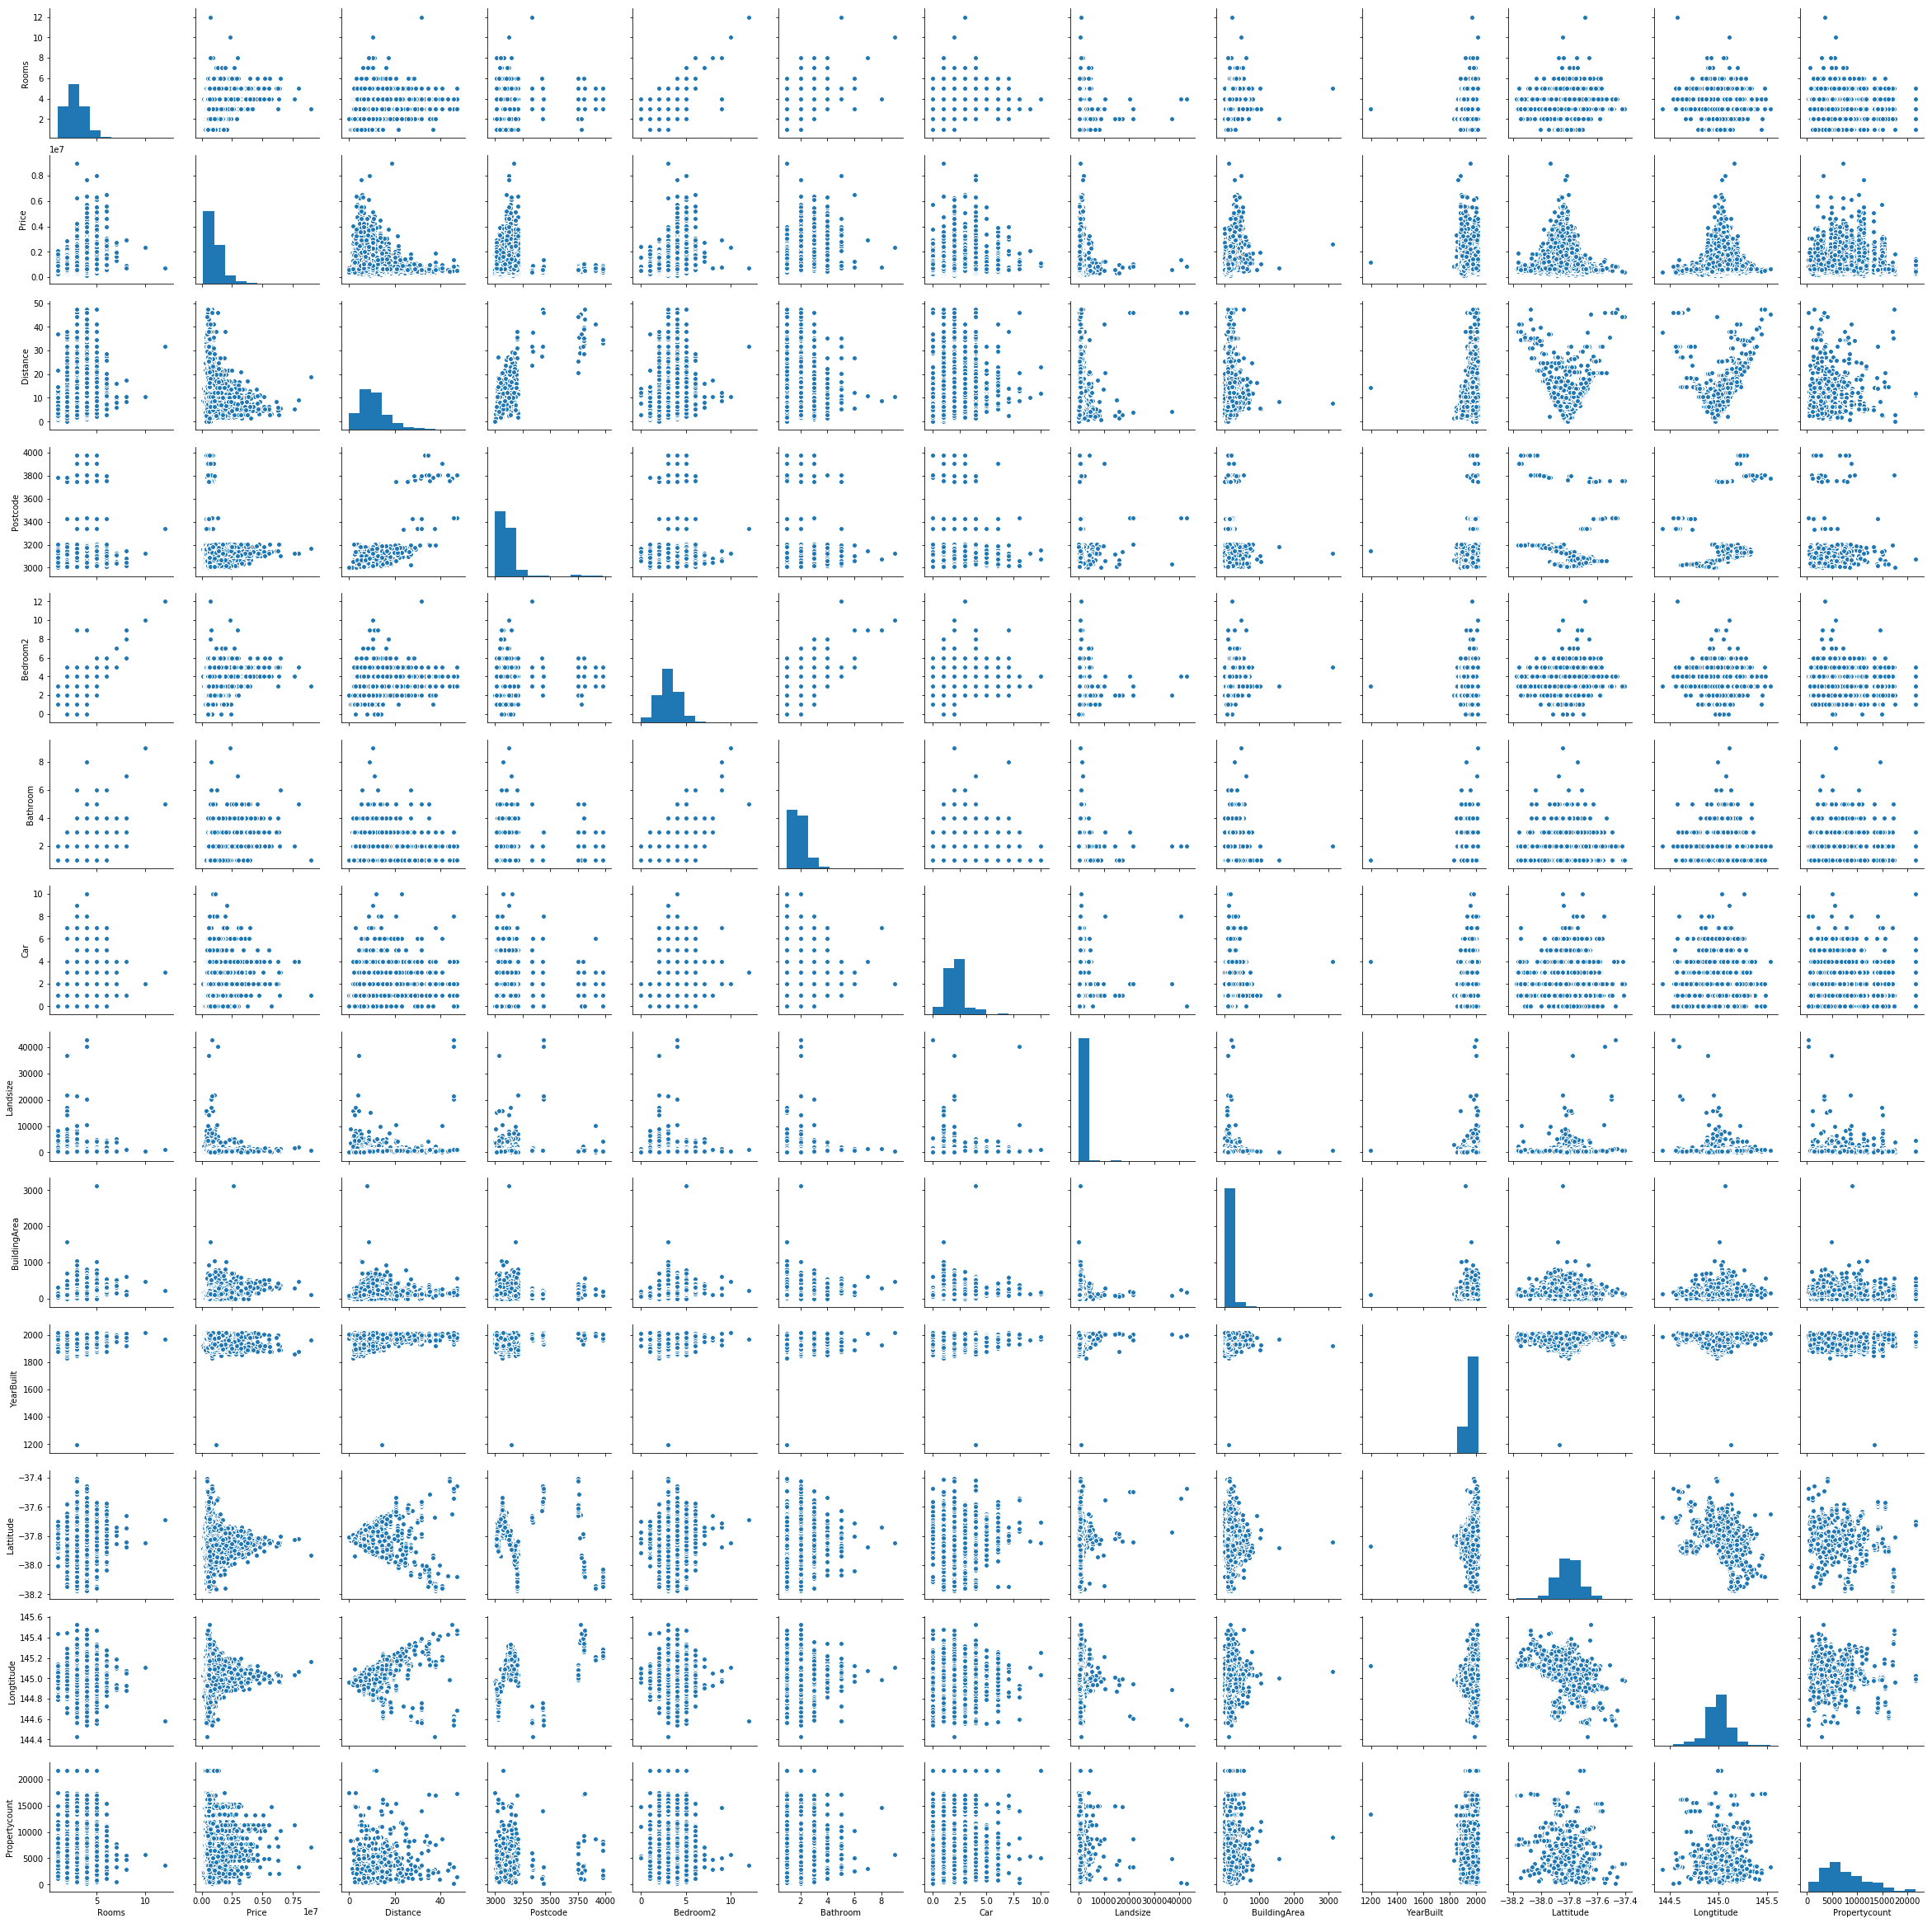

In [13]:
sns.pairplot(df.dropna());

Если скачать картинку, то лучше будет видно.

Треугольники в правых и верхних углах - это дистанция от центра в зависиомти от координаты.

Рассмотрим второй столбец (цена). Можно заметить а) есть максимумы цены по коориднатам (похоже на центр) 2) Цена не так сильно зависит от размера жилья, как это могло показаться

Есть выбросы по площади постройки, году постройки. Имеет смысл убрать дома до 1200 и площадью более 1500.

### Зависимость цены от типа жилья и времени

In [14]:
price = df.sort_values("Date", ascending=False).groupby(["Date", 'Type'])[['Price']].mean().reset_index()
price.head()

,Date,Type,Price
0,2016-01-28,h,1.205000e+06
1,2016-01-28,u,8.130000e+05
2,2016-03-09,h,1.373916e+06
3,2016-03-09,t,8.763793e+05
4,2016-03-09,u,6.204919e+05


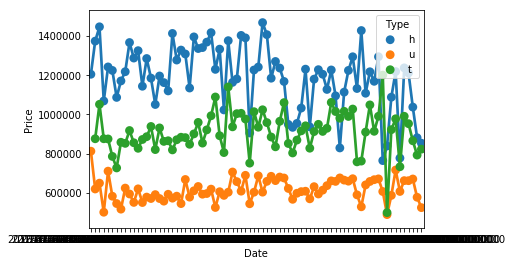

In [15]:
sns.pointplot(x='Date', y='Price', data=price, hue='Type');

Явного тренда нет

# Пропуски
Работает с данными, где нет пропусков по цене

In [16]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 20 columns):
Suburb           27247 non-null object
Address          27247 non-null object
Rooms            27247 non-null int64
Type             27247 non-null object
Method           27247 non-null object
SellerG          27247 non-null object
Date             27247 non-null datetime64[ns]
Distance         27246 non-null float64
Postcode         27246 non-null float64
Bedroom2         20806 non-null float64
Bathroom         20800 non-null float64
Car              20423 non-null float64
Landsize         17982 non-null float64
BuildingArea     10656 non-null float64
YearBuilt        12084 non-null float64
CouncilArea      27244 non-null object
Lattitude        20993 non-null float64
Longtitude       20993 non-null float64
Regionname       27244 non-null object
Propertycount    27244 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(1), object(7)
memory usage: 4.4+ MB


In [17]:
df_p[df_p.isnull().any(axis=1)]

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,85 Turner St,2,h,S,Biggin,2016-03-12,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.79960,144.99840,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,PI,Biggin,2017-04-03,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.79690,144.99690,Northern Metropolitan,4019.0
10,Abbotsford,129 Charles St,2,h,S,Jellis,2016-07-05,2.5,3067.0,2.0,1.0,0.0,181.0,NaN,NaN,Yarra City Council,-37.80410,144.99530,Northern Metropolitan,4019.0
15,Abbotsford,217 Langridge St,3,h,S,Jellis,2016-08-10,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0
16,Abbotsford,18a Mollison St,2,t,S,Jellis,2016-08-10,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0
17,Abbotsford,6/241 Nicholson St,1,u,S,Biggin,2016-08-10,2.5,3067.0,1.0,1.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.80080,144.99730,Northern Metropolitan,4019.0
19,Abbotsford,403/609 Victoria St,2,u,S,Dingle,2016-08-10,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0
21,Abbotsford,25/84 Trenerry Cr,2,u,SP,Biggin,2016-10-12,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0
22,Abbotsford,106/119 Turner St,1,u,SP,Purplebricks,2016-10-12,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0
23,Abbotsford,411/8 Grosvenor St,2,u,VB,Jellis,2016-12-11,2.5,3067.0,2.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.81100,145.00670,Northern Metropolitan,4019.0


Как видим, пропуски идут "пачками". "Bedroom2" из-за скорелированости с Room (было показано ранее). Коориднаты можно брать как средние по району\улице. 

In [18]:
df_p.drop('Bedroom2', axis=1, inplace=True)
df_p.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,85 Turner St,2,h,S,Biggin,2016-03-12,2.5,3067.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,S,Biggin,2016-04-02,2.5,3067.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,SP,Biggin,2017-04-03,2.5,3067.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,PI,Biggin,2017-04-03,2.5,3067.0,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,VB,Nelson,2016-04-06,2.5,3067.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0


Ввиду громоздкости это не вошло в ноутбук, так что пусть будет как факт: четкой **связи между** риэлетром\типом постройки и пропусками **нет**. У всех риэлтеров есть пропуски. Их где-то ~50%. Похоже, что это какая-то внутреняя особеность объявлений.

## Восстановление пропусков
Для начала преобразуем формат улицы: вначале идет номер дома, потом название улицы. Уберем номер дома.
Для каждой улицы посчитаем среднюю кооридианту среди непропусов:

In [19]:
df_p['Address'] = df_p['Address'].apply(lambda x: ' '.join(x.split()[1:]))
df_p.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,Turner St,2,h,S,Biggin,2016-03-12,2.5,3067.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,Bloomburg St,2,h,S,Biggin,2016-04-02,2.5,3067.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,Charles St,3,h,SP,Biggin,2017-04-03,2.5,3067.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,Federation La,3,h,PI,Biggin,2017-04-03,2.5,3067.0,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,Park St,4,h,VB,Nelson,2016-04-06,2.5,3067.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0


### Пропуски координат
Сделаем их как среднее по улице\району\почтовому коду

In [20]:
df_full_cor = df_raw[['Suburb', 'Address', 'Postcode', 'Lattitude', 'Longtitude']].dropna()
df_full_cor['Address'] = df_full_cor['Address'].apply(lambda x: ' '.join(x.split()[1:]))
df_full_cor.head()

,Suburb,Address,Postcode,Lattitude,Longtitude
0,Abbotsford,Studley St,3067.0,-37.8014,144.9958
1,Abbotsford,Turner St,3067.0,-37.7996,144.9984
2,Abbotsford,Bloomburg St,3067.0,-37.8079,144.9934
3,Abbotsford,Victoria St,3067.0,-37.8114,145.0116
4,Abbotsford,Charles St,3067.0,-37.8093,144.9944


In [21]:
def cor_replacer(x, col):
    if not pd.isnull(x[col]):
        return x[col]
    
    if x['Address'] in df_full_cor['Address'].values:
        return df_full_cor[df_full_cor['Address'] == x['Address']][col].mean()
    
    if x['Suburb'] in df_full_cor['Suburb'].values:
        return df_full_cor[df_full_cor['Suburb'] == x['Suburb']][col].mean()
    
    if x['Postcode'] in df_full_cor['Postcode'].values:
        return df_full_cor[df_full_cor['Postcode'] == x['Postcode']][col].mean() 
    
    print(x.Suburb, col)

In [22]:
df_p['Lattitude'] = df_p.apply(cor_replacer, axis=1, col='Lattitude')
df_p['Longtitude'] = df_p.apply(cor_replacer, axis=1, col='Longtitude')

### Пропуски Bathroom, Car, Landsize, BuildingArea, YearBuilt 
Аналогично прошлому, но с учетом типа жилья

In [23]:
df_full_cor = df_raw[['Suburb', 'Address', 'Postcode', 'Type', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']].dropna()
df_full_cor['Address'] = df_full_cor['Address'].apply(lambda x: ' '.join(x.split()[1:]))
df_full_cor.head()

,Suburb,Address,Postcode,Type,Bathroom,Car,Landsize,BuildingArea,YearBuilt
2,Abbotsford,Bloomburg St,3067.0,h,1.0,0.0,156.0,79.0,1900.0
4,Abbotsford,Charles St,3067.0,h,2.0,0.0,134.0,150.0,1900.0
6,Abbotsford,Park St,3067.0,h,1.0,2.0,120.0,142.0,2014.0
7,Abbotsford,Maugie St,3067.0,h,2.0,2.0,400.0,220.0,2006.0
11,Abbotsford,Yarra St,3067.0,h,2.0,0.0,245.0,210.0,1910.0


In [24]:
def value_replacer(x, col):
    if not pd.isnull(x[col]):
        return x[col]
    
    if x['Address'] in df_full_cor['Address'].values:
        return df_full_cor[df_full_cor['Address'] == x['Address']][col].mean()
    
    if x['Suburb'] in df_full_cor['Suburb'].values:
        return df_full_cor[df_full_cor['Suburb'] == x['Suburb']][col].mean()
    
    if x['Postcode'] in df_full_cor['Postcode'].values:
        return df_full_cor[df_full_cor['Postcode'] == x['Postcode']][col].mean() 
    
    print(x.Suburb, col)

In [25]:
def cor_replacer(x, col):
    if not pd.isnull(x[col]):
        return x[col]
    
    if x['Address'] in df_full_cor['Address'].values:
        return df_full_cor[df_full_cor['Address'] == x['Address']][col].mean()
    
    if x['Suburb'] in df_full_cor['Suburb'].values:
        return df_full_cor[df_full_cor['Suburb'] == x['Suburb']][col].mean()
    
    if x['Postcode'] in df_full_cor['Postcode'].values:
        return df_full_cor[df_full_cor['Postcode'] == x['Postcode']][col].mean() 
    
    print(x.Suburb, col, x.Type)
    return df_full_cor[col].mean()

In [26]:
df_p['Bathroom'] = df_p.apply(cor_replacer, axis=1, col='Bathroom')
df_p['Car'] = df_p.apply(cor_replacer, axis=1, col='Car')
df_p['Landsize'] = df_p.apply(cor_replacer, axis=1, col='Landsize')
df_p['BuildingArea'] = df_p.apply(cor_replacer, axis=1, col='BuildingArea')
df_p['YearBuilt'] = df_p.apply(cor_replacer, axis=1, col='YearBuilt')

Clyde North Bathroom h
Lynbrook Bathroom h
Tecoma Bathroom h
Heatherton Bathroom h
Clyde North Bathroom h
Plenty Bathroom h
Lilydale Bathroom h
Lilydale Bathroom h
Heatherton Bathroom u
Clyde North Car h
Lynbrook Car h
Tecoma Car h
Heatherton Car h
Clyde North Car h
Plenty Car h
Lilydale Car h
Lilydale Car h
Heatherton Car u
Clyde North Landsize h
Lynbrook Landsize h
Tecoma Landsize h
Heatherton Landsize h
Clyde North Landsize h
Plenty Landsize h
Lilydale Landsize h
Lilydale Landsize h
Lilydale Landsize h
Wonga Park Landsize h
Lynbrook Landsize h
Ferny Creek Landsize h
Lilydale Landsize h
Clyde North Landsize h
Heatherton Landsize u
Clyde North BuildingArea h
Lynbrook BuildingArea h
Tecoma BuildingArea h
Heatherton BuildingArea h
Silvan BuildingArea h
Clyde North BuildingArea h
Silvan BuildingArea h
Plenty BuildingArea h
Lilydale BuildingArea h
Lilydale BuildingArea h
Lilydale BuildingArea h
Plenty BuildingArea h
Heatherton BuildingArea h
Lynbrook BuildingArea h
Coldstream BuildingArea

In [27]:
drop = np.invert(df_p.isnull().any(axis=1))

In [28]:
df_p[df_p.isnull().any(axis=1)]

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
18523,Footscray,Stafford St,2,u,S,Jas,2017-07-15,5.1,3011.0,1.00,1.00,233.75,115.50,1932.50,NaN,-37.788894,144.954865,NaN,NaN
26888,Camberwell,Kingsley St,2,h,VB,Jellis,2017-11-11,7.7,3124.0,2.25,1.25,418.00,235.50,1947.25,NaN,-37.843666,145.025753,NaN,NaN
29483,Fawkner Lot,Brian St,3,h,SP,Brad,2018-06-01,NaN,NaN,1.25,1.75,526.25,123.25,1970.50,NaN,-37.784888,145.043468,NaN,NaN


# Построение модели
Для тестирования будет использовать 20% данных.
Обучение на 80%.

Т.к. это задача регресии, то в качестве метрики здесь будет использоваться Mean Squared Error. Это связано с тем, что модель не должна допускать больших отклонений от истиной стоимости. В самом деле, предположим, что у нас есть 5 домов, которые стоят по 1000. Пусть первая модель даст предсказания 1000, 500, 1000, 1000, 1000, вторая 900 900 900 900 900. У обеих моделей абсолюная ошибка будет одинаковой (значит, с точки зрения метрик абсолютных ошибок - модели одинаковы), но на деле первая модель хуже. Это связано с тем, что человек, который продал дом в 2 раза дешевле, будет крайне недоволен.

В задаче есть сметь категориальных и количественных признаков. Поэтому для решения будем использовать деревья. Так же деревья не так сильно бояться выбросов и плохого масштаба признаков. 

Данные имеют распределение по времени, так что будет использовать более новые для теста.

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
import xgboost
from sklearn.preprocessing import LabelEncoder 
from collections import defaultdict
from sklearn.metrics import mean_squared_error

## Работа с фичами
1) переботаем дату. Учитывать конкретную неделю\день не имеет смысла: продажа\покупки долгий и заранее планируемый процесс.

In [30]:
df_p['year'] = df_p['Date'].apply(lambda x: x.year)
df_p['month'] = df_p['Date'].apply(lambda x: x.month)
df_p.drop('Date', axis=1, inplace=True)

In [31]:
df_p.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,year,month
1,Abbotsford,Turner St,2,h,S,Biggin,2.5,3067.0,1.0,1.0,202.0,115.25,1951.25,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,2016,3
2,Abbotsford,Bloomburg St,2,h,S,Biggin,2.5,3067.0,1.0,0.0,156.0,79.00,1900.00,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,2016,4
4,Abbotsford,Charles St,3,h,SP,Biggin,2.5,3067.0,2.0,0.0,134.0,150.00,1900.00,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,2017,4
5,Abbotsford,Federation La,3,h,PI,Biggin,2.5,3067.0,2.0,1.0,94.0,119.00,2004.00,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0,2017,4
6,Abbotsford,Park St,4,h,VB,Nelson,2.5,3067.0,1.0,2.0,120.0,142.00,2014.00,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0,2016,4


Уберем 3 фичи с пропусками непонятный природы

In [32]:
y = np.log(df.Price.values[drop])
X = df_p[drop]

In [33]:
split_id = int(0.8*X.shape[0])
split_id

21795

Закодируем категориальные данные данные. Кодировщики сохранятся в словаре для дальнейшего использования.

In [34]:
decoders = defaultdict(LabelEncoder)

In [35]:
categorial_data = ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Postcode', 'CouncilArea', 'Regionname']

In [36]:
for col in categorial_data:
    print(col)
    X[col] = decoders[col].fit_transform(X[col])

Suburb
Address
Type
Method


/home/alexander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


SellerG
Postcode
CouncilArea
Regionname


In [37]:
X[X.isnull().any(axis=1)]

,Suburb,Address,Rooms,Type,Method,SellerG,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,year,month


Разделим на тест и треин

In [38]:
X_train, X_test = X[:split_id], X[split_id:]
y_train, y_test = y[:split_id], y[split_id:]

In [39]:
X_train.shape, X_test.shape

((21795, 20), (5449, 20))

Поиск лучших гиперпараметров для случайного леса. В случае случайного леса большее количество деревьев не должно ухудать количество предсказаний (проворено, это так). Поэтому будем настраиваеть только глубину, в целях экономии времени. В дальнейшем будет показано, что файнтьюн не особо помогает и нет смысла тратить на машинное него время.


Для кросвалидации будем использовать разделение на 4 фолда с перемешиванием. Это компенсирует эффект заглядывания "в будущее". Cпойлер: дата окажется не очень важной фичей.

In [40]:
%%time
params = {'n_estimators':np.arange(10, 120, 10),
          'max_depth':np.arange(1, 12, 2)
         }

params = {'max_depth':np.arange(1, 25, 2)
         }

best_model = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=1984), 
                          params, 
                          scoring='neg_mean_squared_error', 
                          cv=KFold(n_splits=4, random_state=1984, shuffle=True),
                          n_jobs=-1)
best_model.fit(X_test, y_test)

CPU times: user 3.14 s, sys: 72.2 ms, total: 3.21 s
Wall time: 20 s


In [41]:
best_model.best_params_

{'max_depth': 17}

In [42]:
%%time

rf_reg = RandomForestRegressor(n_estimators=2000, max_depth=17, n_jobs=-1, random_state=1984)
rf_reg.fit(X_train, y_train)

pred = rf_reg.predict(X_test)

CPU times: user 6min 24s, sys: 1.07 s, total: 6min 26s
Wall time: 1min 4s


In [43]:
mean_squared_error(y_test, pred)

0.041857503425255745

В среднем ошибаемся на 15% цены:

In [44]:
np.mean(np.abs(np.exp(pred) - np.exp(y_test))) / np.exp(y_test).mean()

0.15779751574762796

## Важность фич

In [45]:
f_impt=pd.DataFrame({'value':rf_reg.feature_importances_,
                     'columns':X_test.columns})
f_impt.head()

,columns,value
0,Suburb,0.008155
1,Address,0.011769
2,Rooms,0.128388
3,Type,0.253228
4,Method,0.005646


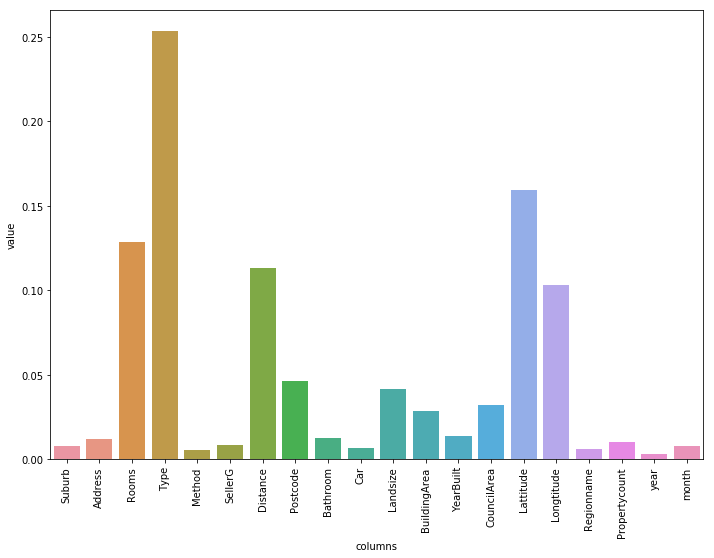

In [46]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

g = sns.barplot(x='columns', y='value', data=f_impt, ax=ax);
g.set_xticklabels(g.get_xticklabels(), rotation=90);

Вполне ожидаемо, что наиболее важными фичами оказались Количество комнат, тип жилья и расстояние до центра.

Улица и район имеют малое значение. Возможно, что это компенсированно фичами широты и долготы, а так же индекса, которые тоже отвечают за географическое положение. Вообще, это не одно и тоже, но достаточно близко.

Количество парковочных мест оказалось не слишком важной фичей, что странно.

# Буст
Попробуем более сложную модель дерева. Ради эксперимента, попробуем её переобучить на тестовую выборку.
Поиск оптимальных параметров будет делать с помощью гиперопта.

In [47]:
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

In [48]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

In [49]:
def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    #return predictions
    score = mean_squared_error(y_test, predictions)
    # TODO: Add the importance for the selected features
    with open('../export/log_boost.txt', 'a') as f:
        print("\tScore {0}".format(score), num_round, params, file=f, sep='\t')
    print("\tScore {0}\n\n".format(score))
    loss = score
    return {'loss': loss, 'status': STATUS_OK}

In [50]:
space = {
    'n_estimators': hp.quniform('n_estimators', 30, 350, 1),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'eval_metric': 'rmse',
    'objective': 'reg:linear',
    'nthread': 7,
    'booster': 'gbtree',
    'silent': 1,
    'seed': 1984
}

In [51]:
best = fmin(score, space, algo=tpe.suggest, max_evals=100)

Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.42500000000000004, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 87.0, 'nthread': 7, 'objective': 'reg:linear', 'seed': 1984, 'silent': 1, 'subsample': 0.75}
[0]	eval-rmse:7.60733	train-rmse:7.61891
[1]	eval-rmse:4.38339	train-rmse:4.3898
[2]	eval-rmse:2.53246	train-rmse:2.53695
[3]	eval-rmse:1.47686	train-rmse:1.47474
[4]	eval-rmse:0.876136	train-rmse:0.872699
[5]	eval-rmse:0.541142	train-rmse:0.53788
[6]	eval-rmse:0.366989	train-rmse:0.360857
[7]	eval-rmse:0.282928	train-rmse:0.275557
[8]	eval-rmse:0.247236	train-rmse:0.237343
[9]	eval-rmse:0.232152	train-rmse:0.221625
[10]	eval-rmse:0.225414	train-rmse:0.211766
[11]	eval-rmse:0.222583	train-rmse:0.208037
[12]	eval-rmse:0.221473	train-rmse:0.205642
[13]	eval-rmse:0.220797	train-rmse:0.203686
[14]	eval-rmse:0.220216	train-rmse:0.201975
[15]	eval-rmse:0.218827	train-rmse:0.198695
[16]	eval-rmse:0.218562	train-r

[89]	eval-rmse:0.206116	train-rmse:0.189712
[90]	eval-rmse:0.206114	train-rmse:0.189712
[91]	eval-rmse:0.206066	train-rmse:0.189594
[92]	eval-rmse:0.20607	train-rmse:0.189441
[93]	eval-rmse:0.206036	train-rmse:0.189326
[94]	eval-rmse:0.205829	train-rmse:0.189085
[95]	eval-rmse:0.205829	train-rmse:0.189085
[96]	eval-rmse:0.205833	train-rmse:0.189019
[97]	eval-rmse:0.205833	train-rmse:0.189019
[98]	eval-rmse:0.205833	train-rmse:0.189019
[99]	eval-rmse:0.205781	train-rmse:0.188864
[100]	eval-rmse:0.205681	train-rmse:0.188683
[101]	eval-rmse:0.205602	train-rmse:0.188519
[102]	eval-rmse:0.205581	train-rmse:0.188362
[103]	eval-rmse:0.205582	train-rmse:0.188362
[104]	eval-rmse:0.205582	train-rmse:0.188362
[105]	eval-rmse:0.205508	train-rmse:0.18832
[106]	eval-rmse:0.205419	train-rmse:0.188147
[107]	eval-rmse:0.205418	train-rmse:0.188147
[108]	eval-rmse:0.205418	train-rmse:0.188147
[109]	eval-rmse:0.205418	train-rmse:0.188147
[110]	eval-rmse:0.205411	train-rmse:0.18812
[111]	eval-rmse:0.205412

[273]	eval-rmse:0.204228	train-rmse:0.183376
[274]	eval-rmse:0.204188	train-rmse:0.183281
[275]	eval-rmse:0.204188	train-rmse:0.183281
[276]	eval-rmse:0.204187	train-rmse:0.183281
[277]	eval-rmse:0.204189	train-rmse:0.183281
[278]	eval-rmse:0.204189	train-rmse:0.183281
[279]	eval-rmse:0.20415	train-rmse:0.183218
[280]	eval-rmse:0.204149	train-rmse:0.183218
[281]	eval-rmse:0.204149	train-rmse:0.183218
[282]	eval-rmse:0.20415	train-rmse:0.183218
[283]	eval-rmse:0.204169	train-rmse:0.183135
[284]	eval-rmse:0.204152	train-rmse:0.183078
[285]	eval-rmse:0.204152	train-rmse:0.183078
[286]	eval-rmse:0.204152	train-rmse:0.183078
[287]	eval-rmse:0.204113	train-rmse:0.182963
[288]	eval-rmse:0.204113	train-rmse:0.182963
[289]	eval-rmse:0.204115	train-rmse:0.182963
[290]	eval-rmse:0.204115	train-rmse:0.182963
[291]	eval-rmse:0.204114	train-rmse:0.182963
[292]	eval-rmse:0.204085	train-rmse:0.182827
[293]	eval-rmse:0.204084	train-rmse:0.182827
[294]	eval-rmse:0.204085	train-rmse:0.182827
[295]	eval-r

[102]	eval-rmse:0.218638	train-rmse:0.206875
[103]	eval-rmse:0.218649	train-rmse:0.206875
[104]	eval-rmse:0.21863	train-rmse:0.206748
[105]	eval-rmse:0.218298	train-rmse:0.206425
[106]	eval-rmse:0.218184	train-rmse:0.206318
[107]	eval-rmse:0.218097	train-rmse:0.206186
[108]	eval-rmse:0.218121	train-rmse:0.206185
[109]	eval-rmse:0.217872	train-rmse:0.20596
[110]	eval-rmse:0.217867	train-rmse:0.205959
[111]	eval-rmse:0.217715	train-rmse:0.205696
[112]	eval-rmse:0.217716	train-rmse:0.205696
[113]	eval-rmse:0.217722	train-rmse:0.205697
[114]	eval-rmse:0.217716	train-rmse:0.205696
[115]	eval-rmse:0.217711	train-rmse:0.205696
[116]	eval-rmse:0.217712	train-rmse:0.205695
[117]	eval-rmse:0.217713	train-rmse:0.205695
[118]	eval-rmse:0.21771	train-rmse:0.205696
[119]	eval-rmse:0.21771	train-rmse:0.205696
[120]	eval-rmse:0.217712	train-rmse:0.205695
[121]	eval-rmse:0.217707	train-rmse:0.205699
[122]	eval-rmse:0.217708	train-rmse:0.205697
[123]	eval-rmse:0.217714	train-rmse:0.205695
[124]	eval-rms

[4]	eval-rmse:5.03577	train-rmse:5.07593
[5]	eval-rmse:4.15928	train-rmse:4.1951
[6]	eval-rmse:3.43106	train-rmse:3.46929
[7]	eval-rmse:2.83248	train-rmse:2.87209
[8]	eval-rmse:2.3433	train-rmse:2.38109
[9]	eval-rmse:1.9422	train-rmse:1.97844
[10]	eval-rmse:1.61143	train-rmse:1.6485
[11]	eval-rmse:1.34397	train-rmse:1.37824
[12]	eval-rmse:1.12386	train-rmse:1.15806
[13]	eval-rmse:0.948142	train-rmse:0.979682
[14]	eval-rmse:0.804155	train-rmse:0.836252
[15]	eval-rmse:0.694648	train-rmse:0.720817
[16]	eval-rmse:0.605139	train-rmse:0.630595
[17]	eval-rmse:0.53567	train-rmse:0.559255
[18]	eval-rmse:0.484327	train-rmse:0.504286
[19]	eval-rmse:0.443443	train-rmse:0.462323
[20]	eval-rmse:0.414427	train-rmse:0.430832
[21]	eval-rmse:0.392175	train-rmse:0.406571
[22]	eval-rmse:0.374342	train-rmse:0.388096
[23]	eval-rmse:0.360747	train-rmse:0.373972
[24]	eval-rmse:0.351031	train-rmse:0.363237
[25]	eval-rmse:0.343063	train-rmse:0.354755
[26]	eval-rmse:0.337839	train-rmse:0.347729
[27]	eval-rmse:0.

[190]	eval-rmse:0.240758	train-rmse:0.242078
[191]	eval-rmse:0.240636	train-rmse:0.241986
[192]	eval-rmse:0.240456	train-rmse:0.241898
[193]	eval-rmse:0.240387	train-rmse:0.241824
[194]	eval-rmse:0.240323	train-rmse:0.241751
[195]	eval-rmse:0.24023	train-rmse:0.241669
[196]	eval-rmse:0.240197	train-rmse:0.241578
[197]	eval-rmse:0.240089	train-rmse:0.241503
[198]	eval-rmse:0.239943	train-rmse:0.24143
[199]	eval-rmse:0.239891	train-rmse:0.241365
[200]	eval-rmse:0.239887	train-rmse:0.241306
[201]	eval-rmse:0.239805	train-rmse:0.241227
[202]	eval-rmse:0.239783	train-rmse:0.241145
[203]	eval-rmse:0.239776	train-rmse:0.241072
[204]	eval-rmse:0.239685	train-rmse:0.240996
[205]	eval-rmse:0.239729	train-rmse:0.240922
[206]	eval-rmse:0.239786	train-rmse:0.240854
[207]	eval-rmse:0.239661	train-rmse:0.240791
[208]	eval-rmse:0.239572	train-rmse:0.240709
[209]	eval-rmse:0.239512	train-rmse:0.240647
[210]	eval-rmse:0.239428	train-rmse:0.2406
[211]	eval-rmse:0.239335	train-rmse:0.240533
[212]	eval-rms

[30]	eval-rmse:0.217936	train-rmse:0.192455
[31]	eval-rmse:0.217819	train-rmse:0.192229
[32]	eval-rmse:0.217348	train-rmse:0.191696
[33]	eval-rmse:0.217184	train-rmse:0.191539
[34]	eval-rmse:0.216988	train-rmse:0.191171
[35]	eval-rmse:0.216819	train-rmse:0.190954
[36]	eval-rmse:0.216722	train-rmse:0.190777
[37]	eval-rmse:0.216764	train-rmse:0.190538
[38]	eval-rmse:0.216953	train-rmse:0.189862
[39]	eval-rmse:0.216923	train-rmse:0.189519
[40]	eval-rmse:0.217256	train-rmse:0.188859
[41]	eval-rmse:0.217422	train-rmse:0.188661
[42]	eval-rmse:0.217535	train-rmse:0.188388
[43]	eval-rmse:0.217519	train-rmse:0.18839
[44]	eval-rmse:0.217546	train-rmse:0.188389
[45]	eval-rmse:0.217643	train-rmse:0.187913
[46]	eval-rmse:0.217651	train-rmse:0.18772
[47]	eval-rmse:0.217666	train-rmse:0.187719
[48]	eval-rmse:0.217663	train-rmse:0.187719
[49]	eval-rmse:0.218163	train-rmse:0.18744
[50]	eval-rmse:0.218034	train-rmse:0.18705
[51]	eval-rmse:0.218066	train-rmse:0.186936
[52]	eval-rmse:0.217867	train-rmse:0

[215]	eval-rmse:0.217289	train-rmse:0.179451
[216]	eval-rmse:0.217281	train-rmse:0.179452
[217]	eval-rmse:0.217276	train-rmse:0.179453
[218]	eval-rmse:0.217063	train-rmse:0.179057
[219]	eval-rmse:0.217063	train-rmse:0.179057
[220]	eval-rmse:0.217058	train-rmse:0.179057
[221]	eval-rmse:0.217062	train-rmse:0.179057
[222]	eval-rmse:0.21705	train-rmse:0.179058
[223]	eval-rmse:0.217056	train-rmse:0.179057
[224]	eval-rmse:0.217055	train-rmse:0.179057
[225]	eval-rmse:0.217047	train-rmse:0.179059
[226]	eval-rmse:0.217319	train-rmse:0.178879
[227]	eval-rmse:0.217317	train-rmse:0.178879
[228]	eval-rmse:0.217321	train-rmse:0.178879
[229]	eval-rmse:0.21721	train-rmse:0.178688
[230]	eval-rmse:0.21722	train-rmse:0.178688
[231]	eval-rmse:0.217216	train-rmse:0.178687
[232]	eval-rmse:0.217212	train-rmse:0.178687
[233]	eval-rmse:0.217226	train-rmse:0.178689
[234]	eval-rmse:0.217239	train-rmse:0.178692
[235]	eval-rmse:0.217217	train-rmse:0.178687
[236]	eval-rmse:0.217115	train-rmse:0.178552
[237]	eval-rm

[43]	eval-rmse:0.208764	train-rmse:0.195975
[44]	eval-rmse:0.208585	train-rmse:0.195739
[45]	eval-rmse:0.208439	train-rmse:0.195507
[46]	eval-rmse:0.208288	train-rmse:0.195227
[47]	eval-rmse:0.208206	train-rmse:0.194842
[48]	eval-rmse:0.208176	train-rmse:0.194818
[49]	eval-rmse:0.208127	train-rmse:0.194654
[50]	eval-rmse:0.208035	train-rmse:0.194544
[51]	eval-rmse:0.207769	train-rmse:0.194112
[52]	eval-rmse:0.207559	train-rmse:0.19369
[53]	eval-rmse:0.207549	train-rmse:0.193683
[54]	eval-rmse:0.207533	train-rmse:0.193544
[55]	eval-rmse:0.207511	train-rmse:0.193416
[56]	eval-rmse:0.207322	train-rmse:0.192977
[57]	eval-rmse:0.207371	train-rmse:0.192816
[58]	eval-rmse:0.207049	train-rmse:0.192378
[59]	eval-rmse:0.20706	train-rmse:0.192164
[60]	eval-rmse:0.207027	train-rmse:0.192036
[61]	eval-rmse:0.206955	train-rmse:0.191498
[62]	eval-rmse:0.206954	train-rmse:0.191497
[63]	eval-rmse:0.206953	train-rmse:0.191497
[64]	eval-rmse:0.206952	train-rmse:0.191497
[65]	eval-rmse:0.206952	train-rmse

[77]	eval-rmse:0.210661	train-rmse:0.172162
[78]	eval-rmse:0.210661	train-rmse:0.172162
[79]	eval-rmse:0.210915	train-rmse:0.171526
[80]	eval-rmse:0.210916	train-rmse:0.171526
[81]	eval-rmse:0.210918	train-rmse:0.171526
[82]	eval-rmse:0.21092	train-rmse:0.171526
[83]	eval-rmse:0.210917	train-rmse:0.171526
[84]	eval-rmse:0.210917	train-rmse:0.171526
[85]	eval-rmse:0.210814	train-rmse:0.17132
[86]	eval-rmse:0.210815	train-rmse:0.17132
[87]	eval-rmse:0.210816	train-rmse:0.17132
[88]	eval-rmse:0.210817	train-rmse:0.17132
[89]	eval-rmse:0.210858	train-rmse:0.171105
[90]	eval-rmse:0.210905	train-rmse:0.171
[91]	eval-rmse:0.210902	train-rmse:0.171001
[92]	eval-rmse:0.210903	train-rmse:0.171
[93]	eval-rmse:0.210904	train-rmse:0.171
[94]	eval-rmse:0.210878	train-rmse:0.170576
[95]	eval-rmse:0.210881	train-rmse:0.170576
[96]	eval-rmse:0.210876	train-rmse:0.170576
[97]	eval-rmse:0.210876	train-rmse:0.170576
[98]	eval-rmse:0.210876	train-rmse:0.170576
[99]	eval-rmse:0.210463	train-rmse:0.170232
[1

[84]	eval-rmse:0.207784	train-rmse:0.174784
[85]	eval-rmse:0.207784	train-rmse:0.174784
[86]	eval-rmse:0.207787	train-rmse:0.174784
[87]	eval-rmse:0.207789	train-rmse:0.174784
[88]	eval-rmse:0.207792	train-rmse:0.174785
[89]	eval-rmse:0.20779	train-rmse:0.174784
[90]	eval-rmse:0.207692	train-rmse:0.174651
[91]	eval-rmse:0.207691	train-rmse:0.174651
[92]	eval-rmse:0.20754	train-rmse:0.174549
[93]	eval-rmse:0.207538	train-rmse:0.17455
[94]	eval-rmse:0.207541	train-rmse:0.174549
[95]	eval-rmse:0.207539	train-rmse:0.174549
[96]	eval-rmse:0.207536	train-rmse:0.17455
[97]	eval-rmse:0.207537	train-rmse:0.17455
[98]	eval-rmse:0.207538	train-rmse:0.17455
[99]	eval-rmse:0.207545	train-rmse:0.174549
[100]	eval-rmse:0.207542	train-rmse:0.174549
[101]	eval-rmse:0.207549	train-rmse:0.174388
[102]	eval-rmse:0.207549	train-rmse:0.174388
[103]	eval-rmse:0.207548	train-rmse:0.174388
[104]	eval-rmse:0.20751	train-rmse:0.174228
[105]	eval-rmse:0.207476	train-rmse:0.174048
[106]	eval-rmse:0.207475	train-rm

[72]	eval-rmse:0.21676	train-rmse:0.19648
[73]	eval-rmse:0.216724	train-rmse:0.196478
[74]	eval-rmse:0.216646	train-rmse:0.196291
[75]	eval-rmse:0.216632	train-rmse:0.196291
[76]	eval-rmse:0.216624	train-rmse:0.196292
[77]	eval-rmse:0.216629	train-rmse:0.196291
[78]	eval-rmse:0.216642	train-rmse:0.196291
[79]	eval-rmse:0.216633	train-rmse:0.196291
[80]	eval-rmse:0.21628	train-rmse:0.195981
[81]	eval-rmse:0.216274	train-rmse:0.195981
[82]	eval-rmse:0.216273	train-rmse:0.195981
[83]	eval-rmse:0.216246	train-rmse:0.195983
[84]	eval-rmse:0.216256	train-rmse:0.195981
[85]	eval-rmse:0.216252	train-rmse:0.195982
[86]	eval-rmse:0.216255	train-rmse:0.195981
[87]	eval-rmse:0.216277	train-rmse:0.195981
[88]	eval-rmse:0.216242	train-rmse:0.195787
[89]	eval-rmse:0.21605	train-rmse:0.195607
[90]	eval-rmse:0.216016	train-rmse:0.195607
[91]	eval-rmse:0.216031	train-rmse:0.195606
[92]	eval-rmse:0.215692	train-rmse:0.195323
[93]	eval-rmse:0.21527	train-rmse:0.195097
[94]	eval-rmse:0.215283	train-rmse:0.

[256]	eval-rmse:0.214033	train-rmse:0.190772
	Score 0.045810311506793294


Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 62.0, 'nthread': 7, 'objective': 'reg:linear', 'seed': 1984, 'silent': 1, 'subsample': 0.8500000000000001}
[0]	eval-rmse:12.5532	train-rmse:12.5767
[1]	eval-rmse:11.924	train-rmse:11.9486
[2]	eval-rmse:11.3273	train-rmse:11.3518
[3]	eval-rmse:10.7607	train-rmse:10.7849
[4]	eval-rmse:10.2223	train-rmse:10.2465
[5]	eval-rmse:9.71201	train-rmse:9.73501
[6]	eval-rmse:9.22727	train-rmse:9.24915
[7]	eval-rmse:8.76545	train-rmse:8.78768
[8]	eval-rmse:8.32773	train-rmse:8.34911
[9]	eval-rmse:7.91181	train-rmse:7.93272
[10]	eval-rmse:7.51664	train-rmse:7.53695
[11]	eval-rmse:7.14072	train-rmse:7.16107
[12]	eval-rmse:6.78424	train-rmse:6.80399
[13]	eval-rmse:6.44442	train-rmse:6.46481
[14]	eval-rmse:6.12298	train-rmse:6.1426
[15]	eva

[16]	eval-rmse:0.221858	train-rmse:0.205012
[17]	eval-rmse:0.221485	train-rmse:0.203713
[18]	eval-rmse:0.221482	train-rmse:0.203653
[19]	eval-rmse:0.221248	train-rmse:0.202968
[20]	eval-rmse:0.221249	train-rmse:0.202971
[21]	eval-rmse:0.22089	train-rmse:0.202223
[22]	eval-rmse:0.22089	train-rmse:0.202223
[23]	eval-rmse:0.22089	train-rmse:0.202223
[24]	eval-rmse:0.220292	train-rmse:0.201263
[25]	eval-rmse:0.220293	train-rmse:0.201262
[26]	eval-rmse:0.220087	train-rmse:0.20088
[27]	eval-rmse:0.219841	train-rmse:0.200507
[28]	eval-rmse:0.219648	train-rmse:0.200127
[29]	eval-rmse:0.219649	train-rmse:0.200126
[30]	eval-rmse:0.219648	train-rmse:0.200127
[31]	eval-rmse:0.219506	train-rmse:0.199764
[32]	eval-rmse:0.219505	train-rmse:0.199765
[33]	eval-rmse:0.219431	train-rmse:0.199379
[34]	eval-rmse:0.219264	train-rmse:0.199081
[35]	eval-rmse:0.219266	train-rmse:0.19908
[36]	eval-rmse:0.219196	train-rmse:0.198633
[37]	eval-rmse:0.219251	train-rmse:0.19847
[38]	eval-rmse:0.21925	train-rmse:0.19

[37]	eval-rmse:0.272847	train-rmse:0.278968
[38]	eval-rmse:0.267915	train-rmse:0.274231
[39]	eval-rmse:0.264277	train-rmse:0.270516
[40]	eval-rmse:0.260469	train-rmse:0.266973
[41]	eval-rmse:0.257973	train-rmse:0.264535
[42]	eval-rmse:0.255401	train-rmse:0.262153
[43]	eval-rmse:0.253568	train-rmse:0.260428
[44]	eval-rmse:0.252173	train-rmse:0.258905
[45]	eval-rmse:0.250879	train-rmse:0.257096
[46]	eval-rmse:0.249073	train-rmse:0.255452
[47]	eval-rmse:0.247921	train-rmse:0.254293
[48]	eval-rmse:0.246941	train-rmse:0.252959
[49]	eval-rmse:0.245752	train-rmse:0.251679
[50]	eval-rmse:0.245262	train-rmse:0.250789
[51]	eval-rmse:0.244462	train-rmse:0.249974
[52]	eval-rmse:0.243701	train-rmse:0.248982
[53]	eval-rmse:0.242702	train-rmse:0.248217
[54]	eval-rmse:0.241788	train-rmse:0.247206
[55]	eval-rmse:0.241069	train-rmse:0.246634
[56]	eval-rmse:0.240663	train-rmse:0.24601
[57]	eval-rmse:0.239714	train-rmse:0.245021
[58]	eval-rmse:0.23904	train-rmse:0.244094
[59]	eval-rmse:0.23841	train-rmse:

[85]	eval-rmse:0.211754	train-rmse:0.203065
[86]	eval-rmse:0.211526	train-rmse:0.202708
[87]	eval-rmse:0.211355	train-rmse:0.202485
[88]	eval-rmse:0.211158	train-rmse:0.202195
[89]	eval-rmse:0.210854	train-rmse:0.201878
[90]	eval-rmse:0.210756	train-rmse:0.201732
[91]	eval-rmse:0.210697	train-rmse:0.201685
[92]	eval-rmse:0.210558	train-rmse:0.201485
[93]	eval-rmse:0.210165	train-rmse:0.200834
[94]	eval-rmse:0.209928	train-rmse:0.200428
[95]	eval-rmse:0.209861	train-rmse:0.200321
[96]	eval-rmse:0.209746	train-rmse:0.200211
[97]	eval-rmse:0.209741	train-rmse:0.200095
[98]	eval-rmse:0.209721	train-rmse:0.200081
[99]	eval-rmse:0.209597	train-rmse:0.199868
[100]	eval-rmse:0.209609	train-rmse:0.19974
[101]	eval-rmse:0.209596	train-rmse:0.199731
[102]	eval-rmse:0.20944	train-rmse:0.199573
[103]	eval-rmse:0.209417	train-rmse:0.199382
[104]	eval-rmse:0.209327	train-rmse:0.19925
[105]	eval-rmse:0.209304	train-rmse:0.199131
[106]	eval-rmse:0.209274	train-rmse:0.199035
[107]	eval-rmse:0.209264	tra

[87]	eval-rmse:0.205646	train-rmse:0.175447
[88]	eval-rmse:0.205732	train-rmse:0.175311
[89]	eval-rmse:0.205732	train-rmse:0.175311
[90]	eval-rmse:0.20568	train-rmse:0.175186
[91]	eval-rmse:0.205675	train-rmse:0.175107
[92]	eval-rmse:0.205674	train-rmse:0.175107
[93]	eval-rmse:0.205673	train-rmse:0.175107
[94]	eval-rmse:0.205458	train-rmse:0.174968
[95]	eval-rmse:0.205456	train-rmse:0.174969
[96]	eval-rmse:0.205317	train-rmse:0.174839
[97]	eval-rmse:0.205329	train-rmse:0.174644
[98]	eval-rmse:0.205329	train-rmse:0.174644
[99]	eval-rmse:0.205334	train-rmse:0.174642
[100]	eval-rmse:0.205335	train-rmse:0.174641
[101]	eval-rmse:0.205336	train-rmse:0.174641
[102]	eval-rmse:0.205271	train-rmse:0.17452
[103]	eval-rmse:0.205273	train-rmse:0.17452
[104]	eval-rmse:0.20527	train-rmse:0.174521
[105]	eval-rmse:0.20527	train-rmse:0.174521
[106]	eval-rmse:0.205269	train-rmse:0.174521
[107]	eval-rmse:0.205268	train-rmse:0.174521
[108]	eval-rmse:0.205226	train-rmse:0.174429
[109]	eval-rmse:0.205228	tra

[27]	eval-rmse:0.212806	train-rmse:0.182476
[28]	eval-rmse:0.212771	train-rmse:0.182246
[29]	eval-rmse:0.212878	train-rmse:0.181405
[30]	eval-rmse:0.212874	train-rmse:0.181405
[31]	eval-rmse:0.21257	train-rmse:0.180693
[32]	eval-rmse:0.212569	train-rmse:0.180693
[33]	eval-rmse:0.212557	train-rmse:0.180364
[34]	eval-rmse:0.212557	train-rmse:0.180364
[35]	eval-rmse:0.212297	train-rmse:0.18003
[36]	eval-rmse:0.212239	train-rmse:0.17965
[37]	eval-rmse:0.212081	train-rmse:0.179332
[38]	eval-rmse:0.212082	train-rmse:0.179332
[39]	eval-rmse:0.211937	train-rmse:0.179119
[40]	eval-rmse:0.211931	train-rmse:0.179119
[41]	eval-rmse:0.211926	train-rmse:0.179119
[42]	eval-rmse:0.211929	train-rmse:0.179119
[43]	eval-rmse:0.211928	train-rmse:0.179119
[44]	eval-rmse:0.211937	train-rmse:0.179119
[45]	eval-rmse:0.211634	train-rmse:0.178182
[46]	eval-rmse:0.211637	train-rmse:0.178182
[47]	eval-rmse:0.211768	train-rmse:0.17789
[48]	eval-rmse:0.211767	train-rmse:0.17789
[49]	eval-rmse:0.21177	train-rmse:0.1

[145]	eval-rmse:0.205056	train-rmse:0.175605
[146]	eval-rmse:0.205045	train-rmse:0.175436
[147]	eval-rmse:0.205005	train-rmse:0.175371
[148]	eval-rmse:0.205009	train-rmse:0.175371
[149]	eval-rmse:0.204986	train-rmse:0.175275
[150]	eval-rmse:0.204988	train-rmse:0.175275
[151]	eval-rmse:0.20499	train-rmse:0.175276
[152]	eval-rmse:0.204989	train-rmse:0.175276
[153]	eval-rmse:0.204988	train-rmse:0.175275
[154]	eval-rmse:0.204934	train-rmse:0.175133
[155]	eval-rmse:0.204913	train-rmse:0.175007
[156]	eval-rmse:0.204912	train-rmse:0.175007
[157]	eval-rmse:0.204917	train-rmse:0.175007
[158]	eval-rmse:0.204913	train-rmse:0.175007
[159]	eval-rmse:0.204914	train-rmse:0.175007
[160]	eval-rmse:0.204906	train-rmse:0.174944
[161]	eval-rmse:0.20489	train-rmse:0.174894
[162]	eval-rmse:0.204893	train-rmse:0.174894
[163]	eval-rmse:0.204902	train-rmse:0.174615
[164]	eval-rmse:0.204948	train-rmse:0.174575
[165]	eval-rmse:0.204942	train-rmse:0.174575
[166]	eval-rmse:0.205013	train-rmse:0.174337
[167]	eval-r

[95]	eval-rmse:0.205845	train-rmse:0.186702
[96]	eval-rmse:0.205734	train-rmse:0.186566
[97]	eval-rmse:0.205733	train-rmse:0.186566
[98]	eval-rmse:0.205685	train-rmse:0.18649
[99]	eval-rmse:0.205652	train-rmse:0.186399
[100]	eval-rmse:0.205604	train-rmse:0.186282
[101]	eval-rmse:0.205604	train-rmse:0.186282
[102]	eval-rmse:0.205415	train-rmse:0.186011
[103]	eval-rmse:0.205415	train-rmse:0.186011
[104]	eval-rmse:0.205397	train-rmse:0.185853
[105]	eval-rmse:0.205396	train-rmse:0.185853
[106]	eval-rmse:0.205396	train-rmse:0.185853
[107]	eval-rmse:0.205396	train-rmse:0.185853
[108]	eval-rmse:0.205372	train-rmse:0.185757
[109]	eval-rmse:0.205336	train-rmse:0.185683
[110]	eval-rmse:0.205299	train-rmse:0.185609
[111]	eval-rmse:0.205275	train-rmse:0.185519
[112]	eval-rmse:0.205176	train-rmse:0.185379
[113]	eval-rmse:0.205176	train-rmse:0.185379
[114]	eval-rmse:0.20517	train-rmse:0.185259
[115]	eval-rmse:0.205103	train-rmse:0.185209
[116]	eval-rmse:0.205087	train-rmse:0.185129
[117]	eval-rmse:0

[278]	eval-rmse:0.203706	train-rmse:0.18108
[279]	eval-rmse:0.203706	train-rmse:0.18108
[280]	eval-rmse:0.203706	train-rmse:0.18108
[281]	eval-rmse:0.203706	train-rmse:0.18108
[282]	eval-rmse:0.203676	train-rmse:0.181011
[283]	eval-rmse:0.203644	train-rmse:0.180955
[284]	eval-rmse:0.203644	train-rmse:0.180955
[285]	eval-rmse:0.203644	train-rmse:0.180955
[286]	eval-rmse:0.203644	train-rmse:0.180955
[287]	eval-rmse:0.203644	train-rmse:0.180955
[288]	eval-rmse:0.203644	train-rmse:0.180955
[289]	eval-rmse:0.203644	train-rmse:0.180955
[290]	eval-rmse:0.203644	train-rmse:0.180955
[291]	eval-rmse:0.203675	train-rmse:0.180778
[292]	eval-rmse:0.203675	train-rmse:0.180778
[293]	eval-rmse:0.203675	train-rmse:0.180778
[294]	eval-rmse:0.203675	train-rmse:0.180778
[295]	eval-rmse:0.203675	train-rmse:0.180778
[296]	eval-rmse:0.203675	train-rmse:0.180778
[297]	eval-rmse:0.203605	train-rmse:0.180646
[298]	eval-rmse:0.203605	train-rmse:0.180646
[299]	eval-rmse:0.203605	train-rmse:0.180646
[300]	eval-rms

[149]	eval-rmse:0.204267	train-rmse:0.183586
[150]	eval-rmse:0.204267	train-rmse:0.183586
[151]	eval-rmse:0.204267	train-rmse:0.183586
[152]	eval-rmse:0.204267	train-rmse:0.183586
[153]	eval-rmse:0.204267	train-rmse:0.183586
[154]	eval-rmse:0.204267	train-rmse:0.183586
[155]	eval-rmse:0.204267	train-rmse:0.183586
[156]	eval-rmse:0.204267	train-rmse:0.183586
[157]	eval-rmse:0.204267	train-rmse:0.183586
[158]	eval-rmse:0.204267	train-rmse:0.183586
[159]	eval-rmse:0.204267	train-rmse:0.183586
[160]	eval-rmse:0.204217	train-rmse:0.183511
[161]	eval-rmse:0.204133	train-rmse:0.183408
[162]	eval-rmse:0.20416	train-rmse:0.183361
[163]	eval-rmse:0.204159	train-rmse:0.183296
[164]	eval-rmse:0.204159	train-rmse:0.183296
[165]	eval-rmse:0.204159	train-rmse:0.183296
[166]	eval-rmse:0.204159	train-rmse:0.183296
[167]	eval-rmse:0.204159	train-rmse:0.183296
[168]	eval-rmse:0.204159	train-rmse:0.183296
[169]	eval-rmse:0.204139	train-rmse:0.183227
[170]	eval-rmse:0.204139	train-rmse:0.183227
[171]	eval-

[26]	eval-rmse:1.63619	train-rmse:1.63551
[27]	eval-rmse:1.51621	train-rmse:1.5157
[28]	eval-rmse:1.40603	train-rmse:1.40498
[29]	eval-rmse:1.30408	train-rmse:1.3027
[30]	eval-rmse:1.20955	train-rmse:1.20832
[31]	eval-rmse:1.12276	train-rmse:1.1212
[32]	eval-rmse:1.04301	train-rmse:1.04097
[33]	eval-rmse:0.969172	train-rmse:0.966836
[34]	eval-rmse:0.901053	train-rmse:0.89865
[35]	eval-rmse:0.838457	train-rmse:0.835665
[36]	eval-rmse:0.781013	train-rmse:0.777841
[37]	eval-rmse:0.72791	train-rmse:0.724591
[38]	eval-rmse:0.679107	train-rmse:0.675604
[39]	eval-rmse:0.634147	train-rmse:0.63055
[40]	eval-rmse:0.593096	train-rmse:0.589344
[41]	eval-rmse:0.555205	train-rmse:0.551603
[42]	eval-rmse:0.520652	train-rmse:0.516819
[43]	eval-rmse:0.489157	train-rmse:0.485046
[44]	eval-rmse:0.460422	train-rmse:0.456035
[45]	eval-rmse:0.43442	train-rmse:0.429704
[46]	eval-rmse:0.410989	train-rmse:0.405746
[47]	eval-rmse:0.389528	train-rmse:0.383862
[48]	eval-rmse:0.369334	train-rmse:0.364016
[49]	eval

[212]	eval-rmse:0.205684	train-rmse:0.190803
[213]	eval-rmse:0.205588	train-rmse:0.190711
[214]	eval-rmse:0.205588	train-rmse:0.190711
[215]	eval-rmse:0.205588	train-rmse:0.190711
[216]	eval-rmse:0.205588	train-rmse:0.190711
[217]	eval-rmse:0.205584	train-rmse:0.190668
[218]	eval-rmse:0.205584	train-rmse:0.190668
[219]	eval-rmse:0.205567	train-rmse:0.190619
[220]	eval-rmse:0.205567	train-rmse:0.190619
[221]	eval-rmse:0.205531	train-rmse:0.190578
[222]	eval-rmse:0.205531	train-rmse:0.190578
[223]	eval-rmse:0.205531	train-rmse:0.190578
[224]	eval-rmse:0.205531	train-rmse:0.190578
[225]	eval-rmse:0.205531	train-rmse:0.190578
[226]	eval-rmse:0.205531	train-rmse:0.190578
[227]	eval-rmse:0.205531	train-rmse:0.190578
[228]	eval-rmse:0.205531	train-rmse:0.190578
[229]	eval-rmse:0.205531	train-rmse:0.190578
[230]	eval-rmse:0.205531	train-rmse:0.190578
[231]	eval-rmse:0.205531	train-rmse:0.190578
[232]	eval-rmse:0.205531	train-rmse:0.190578
[233]	eval-rmse:0.205508	train-rmse:0.190538
[234]	eval

[80]	eval-rmse:0.207034	train-rmse:0.188993
[81]	eval-rmse:0.207019	train-rmse:0.188914
[82]	eval-rmse:0.207016	train-rmse:0.188911
[83]	eval-rmse:0.207052	train-rmse:0.188858
[84]	eval-rmse:0.206985	train-rmse:0.18868
[85]	eval-rmse:0.206819	train-rmse:0.188312
[86]	eval-rmse:0.206817	train-rmse:0.188311
[87]	eval-rmse:0.206815	train-rmse:0.18831
[88]	eval-rmse:0.2068	train-rmse:0.188218
[89]	eval-rmse:0.206726	train-rmse:0.188131
[90]	eval-rmse:0.206591	train-rmse:0.187894
[91]	eval-rmse:0.206591	train-rmse:0.187894
[92]	eval-rmse:0.20659	train-rmse:0.187894
[93]	eval-rmse:0.206589	train-rmse:0.187893
[94]	eval-rmse:0.206589	train-rmse:0.187893
[95]	eval-rmse:0.206525	train-rmse:0.187562
[96]	eval-rmse:0.20651	train-rmse:0.18747
[97]	eval-rmse:0.20651	train-rmse:0.18747
[98]	eval-rmse:0.206534	train-rmse:0.187379
[99]	eval-rmse:0.206433	train-rmse:0.187138
[100]	eval-rmse:0.206407	train-rmse:0.187034
[101]	eval-rmse:0.206364	train-rmse:0.186838
[102]	eval-rmse:0.206329	train-rmse:0.1

[33]	eval-rmse:0.216005	train-rmse:0.210216
[34]	eval-rmse:0.215484	train-rmse:0.209399
[35]	eval-rmse:0.215147	train-rmse:0.208867
[36]	eval-rmse:0.21479	train-rmse:0.20853
[37]	eval-rmse:0.214531	train-rmse:0.208101
[38]	eval-rmse:0.214336	train-rmse:0.207498
[39]	eval-rmse:0.214249	train-rmse:0.207367
[40]	eval-rmse:0.214164	train-rmse:0.207116
[41]	eval-rmse:0.213995	train-rmse:0.206911
[42]	eval-rmse:0.213863	train-rmse:0.206594
[43]	eval-rmse:0.21351	train-rmse:0.205915
[44]	eval-rmse:0.213546	train-rmse:0.205779
[45]	eval-rmse:0.213504	train-rmse:0.205696
[46]	eval-rmse:0.213175	train-rmse:0.205325
[47]	eval-rmse:0.213168	train-rmse:0.205105
[48]	eval-rmse:0.212765	train-rmse:0.204746
[49]	eval-rmse:0.212461	train-rmse:0.204372
[50]	eval-rmse:0.212461	train-rmse:0.204372
[51]	eval-rmse:0.212252	train-rmse:0.204159
[52]	eval-rmse:0.212103	train-rmse:0.203595
[53]	eval-rmse:0.211993	train-rmse:0.203382
[54]	eval-rmse:0.211993	train-rmse:0.203382
[55]	eval-rmse:0.211893	train-rmse:

[218]	eval-rmse:0.20837	train-rmse:0.196294
[219]	eval-rmse:0.208371	train-rmse:0.196294
[220]	eval-rmse:0.208372	train-rmse:0.196294
[221]	eval-rmse:0.208372	train-rmse:0.196294
[222]	eval-rmse:0.20837	train-rmse:0.196294
[223]	eval-rmse:0.208371	train-rmse:0.196294
[224]	eval-rmse:0.20837	train-rmse:0.196294
[225]	eval-rmse:0.20837	train-rmse:0.196294
[226]	eval-rmse:0.20837	train-rmse:0.196294
[227]	eval-rmse:0.208369	train-rmse:0.196294
[228]	eval-rmse:0.20837	train-rmse:0.196294
[229]	eval-rmse:0.20837	train-rmse:0.196294
[230]	eval-rmse:0.20837	train-rmse:0.196294
[231]	eval-rmse:0.20837	train-rmse:0.196294
[232]	eval-rmse:0.208371	train-rmse:0.196294
[233]	eval-rmse:0.208371	train-rmse:0.196294
[234]	eval-rmse:0.208371	train-rmse:0.196294
[235]	eval-rmse:0.208372	train-rmse:0.196294
[236]	eval-rmse:0.208299	train-rmse:0.1962
[237]	eval-rmse:0.208299	train-rmse:0.1962
[238]	eval-rmse:0.208299	train-rmse:0.1962
[239]	eval-rmse:0.208299	train-rmse:0.1962
[240]	eval-rmse:0.208301	tr

[79]	eval-rmse:0.208442	train-rmse:0.188391
[80]	eval-rmse:0.208148	train-rmse:0.188241
[81]	eval-rmse:0.208152	train-rmse:0.188241
[82]	eval-rmse:0.208152	train-rmse:0.188241
[83]	eval-rmse:0.208149	train-rmse:0.188241
[84]	eval-rmse:0.208147	train-rmse:0.188241
[85]	eval-rmse:0.208124	train-rmse:0.188025
[86]	eval-rmse:0.208125	train-rmse:0.188025
[87]	eval-rmse:0.208126	train-rmse:0.188025
[88]	eval-rmse:0.208127	train-rmse:0.188025
[89]	eval-rmse:0.208066	train-rmse:0.187893
[90]	eval-rmse:0.208069	train-rmse:0.187893
[91]	eval-rmse:0.208064	train-rmse:0.187893
[92]	eval-rmse:0.20799	train-rmse:0.18777
[93]	eval-rmse:0.207989	train-rmse:0.18777
[94]	eval-rmse:0.207989	train-rmse:0.18777
[95]	eval-rmse:0.207801	train-rmse:0.18753
[96]	eval-rmse:0.2078	train-rmse:0.18753
[97]	eval-rmse:0.207696	train-rmse:0.187339
[98]	eval-rmse:0.207928	train-rmse:0.18718
[99]	eval-rmse:0.207931	train-rmse:0.18718
[100]	eval-rmse:0.207921	train-rmse:0.186964
[101]	eval-rmse:0.207898	train-rmse:0.186

[262]	eval-rmse:0.207087	train-rmse:0.182263
[263]	eval-rmse:0.207085	train-rmse:0.182263
[264]	eval-rmse:0.207084	train-rmse:0.182263
[265]	eval-rmse:0.207083	train-rmse:0.182263
[266]	eval-rmse:0.207079	train-rmse:0.182263
[267]	eval-rmse:0.20704	train-rmse:0.182091
[268]	eval-rmse:0.20704	train-rmse:0.182091
[269]	eval-rmse:0.207043	train-rmse:0.182091
[270]	eval-rmse:0.207043	train-rmse:0.182091
[271]	eval-rmse:0.207044	train-rmse:0.182091
[272]	eval-rmse:0.207039	train-rmse:0.182091
[273]	eval-rmse:0.207042	train-rmse:0.182091
[274]	eval-rmse:0.207044	train-rmse:0.182091
[275]	eval-rmse:0.207098	train-rmse:0.181936
[276]	eval-rmse:0.207095	train-rmse:0.181936
[277]	eval-rmse:0.207097	train-rmse:0.181936
[278]	eval-rmse:0.207099	train-rmse:0.181936
[279]	eval-rmse:0.207099	train-rmse:0.181936
	Score 0.042890149477837466


Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 9, 'min_child_

[163]	eval-rmse:0.205089	train-rmse:0.189044
[164]	eval-rmse:0.205089	train-rmse:0.188986
[165]	eval-rmse:0.205086	train-rmse:0.188984
[166]	eval-rmse:0.205082	train-rmse:0.188983
[167]	eval-rmse:0.204968	train-rmse:0.188769
[168]	eval-rmse:0.204965	train-rmse:0.188768
[169]	eval-rmse:0.20489	train-rmse:0.18866
[170]	eval-rmse:0.204884	train-rmse:0.188616
[171]	eval-rmse:0.204872	train-rmse:0.188506
[172]	eval-rmse:0.204851	train-rmse:0.188441
[173]	eval-rmse:0.204849	train-rmse:0.18844
[174]	eval-rmse:0.204847	train-rmse:0.188439
[175]	eval-rmse:0.204822	train-rmse:0.188375
[176]	eval-rmse:0.204821	train-rmse:0.188374
[177]	eval-rmse:0.204795	train-rmse:0.188306
[178]	eval-rmse:0.204788	train-rmse:0.188271
[179]	eval-rmse:0.204756	train-rmse:0.188211
[180]	eval-rmse:0.204718	train-rmse:0.188035
[181]	eval-rmse:0.204694	train-rmse:0.187957
[182]	eval-rmse:0.204664	train-rmse:0.187892
[183]	eval-rmse:0.204663	train-rmse:0.187892
[184]	eval-rmse:0.204662	train-rmse:0.187891
[185]	eval-rm

[109]	eval-rmse:0.205222	train-rmse:0.18439
[110]	eval-rmse:0.205231	train-rmse:0.184311
[111]	eval-rmse:0.205041	train-rmse:0.184067
[112]	eval-rmse:0.205045	train-rmse:0.183778
[113]	eval-rmse:0.204988	train-rmse:0.183666
[114]	eval-rmse:0.204958	train-rmse:0.183577
[115]	eval-rmse:0.204979	train-rmse:0.183477
[116]	eval-rmse:0.204935	train-rmse:0.18341
[117]	eval-rmse:0.204844	train-rmse:0.183287
[118]	eval-rmse:0.204844	train-rmse:0.183287
[119]	eval-rmse:0.204578	train-rmse:0.182894
[120]	eval-rmse:0.204578	train-rmse:0.182894
[121]	eval-rmse:0.204571	train-rmse:0.182742
[122]	eval-rmse:0.20457	train-rmse:0.182742
[123]	eval-rmse:0.20457	train-rmse:0.182742
[124]	eval-rmse:0.204494	train-rmse:0.182512
[125]	eval-rmse:0.204495	train-rmse:0.182512
[126]	eval-rmse:0.204441	train-rmse:0.182342
[127]	eval-rmse:0.204435	train-rmse:0.182255
[128]	eval-rmse:0.204436	train-rmse:0.182255
[129]	eval-rmse:0.204435	train-rmse:0.182255
[130]	eval-rmse:0.204334	train-rmse:0.182105
[131]	eval-rms

[292]	eval-rmse:0.203404	train-rmse:0.178203
[293]	eval-rmse:0.203404	train-rmse:0.178203
[294]	eval-rmse:0.203404	train-rmse:0.178203
[295]	eval-rmse:0.203404	train-rmse:0.178203
[296]	eval-rmse:0.203404	train-rmse:0.178203
[297]	eval-rmse:0.203402	train-rmse:0.178203
[298]	eval-rmse:0.203401	train-rmse:0.178203
[299]	eval-rmse:0.203403	train-rmse:0.178203
[300]	eval-rmse:0.203404	train-rmse:0.178203
[301]	eval-rmse:0.203403	train-rmse:0.178203
[302]	eval-rmse:0.203403	train-rmse:0.178203
[303]	eval-rmse:0.203404	train-rmse:0.178203
[304]	eval-rmse:0.203404	train-rmse:0.178203
[305]	eval-rmse:0.203346	train-rmse:0.178139
[306]	eval-rmse:0.203346	train-rmse:0.178139
[307]	eval-rmse:0.203346	train-rmse:0.178139
[308]	eval-rmse:0.203347	train-rmse:0.178139
[309]	eval-rmse:0.203348	train-rmse:0.178139
[310]	eval-rmse:0.203336	train-rmse:0.178038
[311]	eval-rmse:0.203335	train-rmse:0.178038
[312]	eval-rmse:0.203336	train-rmse:0.178038
[313]	eval-rmse:0.203335	train-rmse:0.178038
[314]	eval

[127]	eval-rmse:0.206363	train-rmse:0.174367
[128]	eval-rmse:0.206237	train-rmse:0.173985
[129]	eval-rmse:0.206234	train-rmse:0.173985
[130]	eval-rmse:0.206235	train-rmse:0.173985
[131]	eval-rmse:0.206236	train-rmse:0.173985
[132]	eval-rmse:0.206118	train-rmse:0.173896
[133]	eval-rmse:0.206119	train-rmse:0.173896
[134]	eval-rmse:0.206119	train-rmse:0.173896
[135]	eval-rmse:0.20612	train-rmse:0.173896
[136]	eval-rmse:0.206117	train-rmse:0.173896
[137]	eval-rmse:0.206038	train-rmse:0.173706
[138]	eval-rmse:0.206044	train-rmse:0.173706
[139]	eval-rmse:0.206041	train-rmse:0.173706
[140]	eval-rmse:0.206043	train-rmse:0.173706
[141]	eval-rmse:0.206042	train-rmse:0.173706
[142]	eval-rmse:0.206039	train-rmse:0.173706
[143]	eval-rmse:0.206057	train-rmse:0.173603
[144]	eval-rmse:0.206056	train-rmse:0.173603
[145]	eval-rmse:0.206117	train-rmse:0.173401
[146]	eval-rmse:0.206116	train-rmse:0.173401
[147]	eval-rmse:0.206115	train-rmse:0.173401
[148]	eval-rmse:0.206115	train-rmse:0.173401
[149]	eval-

[310]	eval-rmse:0.205974	train-rmse:0.171018
[311]	eval-rmse:0.205971	train-rmse:0.171017
[312]	eval-rmse:0.205972	train-rmse:0.171017
[313]	eval-rmse:0.205968	train-rmse:0.171017
[314]	eval-rmse:0.205966	train-rmse:0.171017
[315]	eval-rmse:0.205963	train-rmse:0.171017
[316]	eval-rmse:0.205967	train-rmse:0.171017
[317]	eval-rmse:0.205969	train-rmse:0.171017
[318]	eval-rmse:0.205969	train-rmse:0.171017
[319]	eval-rmse:0.20597	train-rmse:0.171017
[320]	eval-rmse:0.205971	train-rmse:0.171017
[321]	eval-rmse:0.205974	train-rmse:0.170873
[322]	eval-rmse:0.205969	train-rmse:0.170872
[323]	eval-rmse:0.205968	train-rmse:0.170872
[324]	eval-rmse:0.205968	train-rmse:0.170872
[325]	eval-rmse:0.205968	train-rmse:0.170872
[326]	eval-rmse:0.205895	train-rmse:0.170714
[327]	eval-rmse:0.205893	train-rmse:0.170713
[328]	eval-rmse:0.205892	train-rmse:0.170713
[329]	eval-rmse:0.205888	train-rmse:0.170713
[330]	eval-rmse:0.205885	train-rmse:0.170713
[331]	eval-rmse:0.205885	train-rmse:0.170713
[332]	eval-

[146]	eval-rmse:0.396049	train-rmse:0.392598
[147]	eval-rmse:0.389332	train-rmse:0.385823
[148]	eval-rmse:0.382783	train-rmse:0.379247
[149]	eval-rmse:0.37647	train-rmse:0.372936
[150]	eval-rmse:0.370336	train-rmse:0.366853
[151]	eval-rmse:0.364309	train-rmse:0.360943
[152]	eval-rmse:0.358582	train-rmse:0.355221
[153]	eval-rmse:0.353071	train-rmse:0.349663
[154]	eval-rmse:0.347753	train-rmse:0.344295
[155]	eval-rmse:0.342545	train-rmse:0.339108
[156]	eval-rmse:0.337558	train-rmse:0.334081
[157]	eval-rmse:0.332748	train-rmse:0.329204
[158]	eval-rmse:0.327952	train-rmse:0.324535
[159]	eval-rmse:0.323536	train-rmse:0.320033
[160]	eval-rmse:0.31915	train-rmse:0.315682
[161]	eval-rmse:0.315022	train-rmse:0.311433
[162]	eval-rmse:0.311006	train-rmse:0.307425
[163]	eval-rmse:0.306967	train-rmse:0.303481
[164]	eval-rmse:0.303153	train-rmse:0.299749
[165]	eval-rmse:0.299571	train-rmse:0.29612
[166]	eval-rmse:0.296144	train-rmse:0.292596
[167]	eval-rmse:0.292875	train-rmse:0.289288
[168]	eval-rm

[37]	eval-rmse:0.216058	train-rmse:0.205915
[38]	eval-rmse:0.2149	train-rmse:0.204586
[39]	eval-rmse:0.214191	train-rmse:0.203756
[40]	eval-rmse:0.21367	train-rmse:0.202959
[41]	eval-rmse:0.213152	train-rmse:0.202051
[42]	eval-rmse:0.212681	train-rmse:0.201443
[43]	eval-rmse:0.212521	train-rmse:0.201081
[44]	eval-rmse:0.212095	train-rmse:0.200611
[45]	eval-rmse:0.211539	train-rmse:0.199772
[46]	eval-rmse:0.211153	train-rmse:0.199337
[47]	eval-rmse:0.211091	train-rmse:0.199042
[48]	eval-rmse:0.210838	train-rmse:0.198681
[49]	eval-rmse:0.210786	train-rmse:0.198334
[50]	eval-rmse:0.210561	train-rmse:0.197685
[51]	eval-rmse:0.210161	train-rmse:0.196931
[52]	eval-rmse:0.209711	train-rmse:0.196429
[53]	eval-rmse:0.209348	train-rmse:0.196244
[54]	eval-rmse:0.2093	train-rmse:0.196055
[55]	eval-rmse:0.209244	train-rmse:0.195959
[56]	eval-rmse:0.209243	train-rmse:0.195958
[57]	eval-rmse:0.209243	train-rmse:0.195807
[58]	eval-rmse:0.209138	train-rmse:0.195681
[59]	eval-rmse:0.20912	train-rmse:0.1

[222]	eval-rmse:0.204585	train-rmse:0.185718
[223]	eval-rmse:0.204584	train-rmse:0.185718
[224]	eval-rmse:0.204584	train-rmse:0.185718
[225]	eval-rmse:0.204616	train-rmse:0.18566
[226]	eval-rmse:0.204616	train-rmse:0.18566
[227]	eval-rmse:0.204616	train-rmse:0.18566
[228]	eval-rmse:0.204616	train-rmse:0.18566
[229]	eval-rmse:0.204616	train-rmse:0.18566
[230]	eval-rmse:0.204617	train-rmse:0.18566
[231]	eval-rmse:0.204617	train-rmse:0.18566
[232]	eval-rmse:0.204743	train-rmse:0.185602
[233]	eval-rmse:0.204743	train-rmse:0.185602
[234]	eval-rmse:0.204744	train-rmse:0.185602
[235]	eval-rmse:0.204747	train-rmse:0.18547
[236]	eval-rmse:0.204746	train-rmse:0.18547
[237]	eval-rmse:0.204746	train-rmse:0.185471
[238]	eval-rmse:0.204746	train-rmse:0.18547
[239]	eval-rmse:0.204695	train-rmse:0.185398
[240]	eval-rmse:0.204697	train-rmse:0.185398
[241]	eval-rmse:0.204697	train-rmse:0.185398
[242]	eval-rmse:0.204697	train-rmse:0.185398
[243]	eval-rmse:0.204696	train-rmse:0.185398
[244]	eval-rmse:0.20

[62]	eval-rmse:0.204907	train-rmse:0.172151
[63]	eval-rmse:0.204907	train-rmse:0.172151
[64]	eval-rmse:0.204894	train-rmse:0.172029
[65]	eval-rmse:0.204895	train-rmse:0.171961
[66]	eval-rmse:0.204865	train-rmse:0.171829
[67]	eval-rmse:0.204779	train-rmse:0.171687
[68]	eval-rmse:0.204779	train-rmse:0.171687
[69]	eval-rmse:0.204741	train-rmse:0.17145
[70]	eval-rmse:0.204692	train-rmse:0.171337
[71]	eval-rmse:0.204691	train-rmse:0.17122
[72]	eval-rmse:0.204642	train-rmse:0.170937
[73]	eval-rmse:0.204642	train-rmse:0.170937
[74]	eval-rmse:0.204621	train-rmse:0.170535
[75]	eval-rmse:0.204641	train-rmse:0.170396
[76]	eval-rmse:0.204641	train-rmse:0.170396
[77]	eval-rmse:0.204657	train-rmse:0.170297
[78]	eval-rmse:0.204657	train-rmse:0.170297
[79]	eval-rmse:0.204657	train-rmse:0.170297
[80]	eval-rmse:0.204657	train-rmse:0.170297
[81]	eval-rmse:0.204657	train-rmse:0.170297
[82]	eval-rmse:0.204657	train-rmse:0.170297
[83]	eval-rmse:0.204657	train-rmse:0.170297
[84]	eval-rmse:0.204552	train-rmse

[246]	eval-rmse:0.203405	train-rmse:0.164265
[247]	eval-rmse:0.203404	train-rmse:0.164264
[248]	eval-rmse:0.203404	train-rmse:0.164264
[249]	eval-rmse:0.203404	train-rmse:0.164264
[250]	eval-rmse:0.203404	train-rmse:0.164264
[251]	eval-rmse:0.203404	train-rmse:0.164264
[252]	eval-rmse:0.203404	train-rmse:0.164264
[253]	eval-rmse:0.203404	train-rmse:0.164264
[254]	eval-rmse:0.203412	train-rmse:0.164115
[255]	eval-rmse:0.203413	train-rmse:0.164115
[256]	eval-rmse:0.203413	train-rmse:0.164115
[257]	eval-rmse:0.203413	train-rmse:0.164115
[258]	eval-rmse:0.203413	train-rmse:0.164115
[259]	eval-rmse:0.203412	train-rmse:0.164115
[260]	eval-rmse:0.203412	train-rmse:0.164115
[261]	eval-rmse:0.203412	train-rmse:0.164115
	Score 0.041376587437254884


Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.125, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 4, 'min_child_weight': 3.0, 'n_estimators': 324.0, 'nthread': 7, 'objective': 'reg:lin

[164]	eval-rmse:0.209688	train-rmse:0.203103
[165]	eval-rmse:0.209684	train-rmse:0.203104
[166]	eval-rmse:0.209701	train-rmse:0.202991
[167]	eval-rmse:0.209706	train-rmse:0.20299
[168]	eval-rmse:0.209706	train-rmse:0.20299
[169]	eval-rmse:0.209666	train-rmse:0.202949
[170]	eval-rmse:0.209634	train-rmse:0.202903
[171]	eval-rmse:0.209633	train-rmse:0.202903
[172]	eval-rmse:0.209639	train-rmse:0.202652
[173]	eval-rmse:0.20964	train-rmse:0.202652
[174]	eval-rmse:0.209641	train-rmse:0.202652
[175]	eval-rmse:0.209642	train-rmse:0.202652
[176]	eval-rmse:0.209639	train-rmse:0.202652
[177]	eval-rmse:0.209641	train-rmse:0.202652
[178]	eval-rmse:0.209646	train-rmse:0.20257
[179]	eval-rmse:0.209647	train-rmse:0.20257
[180]	eval-rmse:0.209646	train-rmse:0.20257
[181]	eval-rmse:0.209642	train-rmse:0.202571
[182]	eval-rmse:0.209645	train-rmse:0.20257
[183]	eval-rmse:0.209635	train-rmse:0.202494
[184]	eval-rmse:0.209634	train-rmse:0.202494
[185]	eval-rmse:0.209636	train-rmse:0.202494
[186]	eval-rmse:0

[17]	eval-rmse:0.217672	train-rmse:0.205239
[18]	eval-rmse:0.216608	train-rmse:0.20404
[19]	eval-rmse:0.215923	train-rmse:0.202639
[20]	eval-rmse:0.215315	train-rmse:0.201871
[21]	eval-rmse:0.214371	train-rmse:0.200279
[22]	eval-rmse:0.214297	train-rmse:0.199919
[23]	eval-rmse:0.213947	train-rmse:0.199563
[24]	eval-rmse:0.213717	train-rmse:0.199292
[25]	eval-rmse:0.213625	train-rmse:0.198961
[26]	eval-rmse:0.21351	train-rmse:0.198684
[27]	eval-rmse:0.212872	train-rmse:0.19809
[28]	eval-rmse:0.212868	train-rmse:0.198089
[29]	eval-rmse:0.212839	train-rmse:0.19752
[30]	eval-rmse:0.212531	train-rmse:0.196973
[31]	eval-rmse:0.21208	train-rmse:0.196402
[32]	eval-rmse:0.211853	train-rmse:0.195913
[33]	eval-rmse:0.211811	train-rmse:0.195501
[34]	eval-rmse:0.211557	train-rmse:0.195227
[35]	eval-rmse:0.211325	train-rmse:0.1949
[36]	eval-rmse:0.211278	train-rmse:0.19476
[37]	eval-rmse:0.211077	train-rmse:0.194443
[38]	eval-rmse:0.210995	train-rmse:0.194159
[39]	eval-rmse:0.210992	train-rmse:0.194

[202]	eval-rmse:0.208371	train-rmse:0.184735
[203]	eval-rmse:0.208373	train-rmse:0.184735
[204]	eval-rmse:0.208133	train-rmse:0.184546
[205]	eval-rmse:0.208133	train-rmse:0.184546
[206]	eval-rmse:0.208136	train-rmse:0.184546
[207]	eval-rmse:0.208134	train-rmse:0.184546
[208]	eval-rmse:0.208134	train-rmse:0.184546
[209]	eval-rmse:0.208022	train-rmse:0.184434
[210]	eval-rmse:0.208025	train-rmse:0.184435
[211]	eval-rmse:0.208026	train-rmse:0.184435
[212]	eval-rmse:0.208025	train-rmse:0.184434
[213]	eval-rmse:0.208026	train-rmse:0.184435
[214]	eval-rmse:0.208022	train-rmse:0.184434
[215]	eval-rmse:0.208095	train-rmse:0.184281
[216]	eval-rmse:0.208094	train-rmse:0.184281
[217]	eval-rmse:0.208093	train-rmse:0.184281
[218]	eval-rmse:0.208093	train-rmse:0.184281
[219]	eval-rmse:0.208096	train-rmse:0.184281
[220]	eval-rmse:0.208095	train-rmse:0.184281
[221]	eval-rmse:0.208094	train-rmse:0.184281
[222]	eval-rmse:0.208092	train-rmse:0.184282
[223]	eval-rmse:0.208084	train-rmse:0.183993
[224]	eval

[90]	eval-rmse:1.35031	train-rmse:1.34825
[91]	eval-rmse:1.3178	train-rmse:1.31557
[92]	eval-rmse:1.28617	train-rmse:1.28377
[93]	eval-rmse:1.25538	train-rmse:1.25282
[94]	eval-rmse:1.22527	train-rmse:1.2226
[95]	eval-rmse:1.19598	train-rmse:1.19314
[96]	eval-rmse:1.16739	train-rmse:1.16446
[97]	eval-rmse:1.13969	train-rmse:1.13651
[98]	eval-rmse:1.11266	train-rmse:1.10935
[99]	eval-rmse:1.08624	train-rmse:1.08288
[100]	eval-rmse:1.06071	train-rmse:1.05705
[101]	eval-rmse:1.03567	train-rmse:1.0319
[102]	eval-rmse:1.01113	train-rmse:1.00744
[103]	eval-rmse:0.987514	train-rmse:0.983605
[104]	eval-rmse:0.964234	train-rmse:0.960329
[105]	eval-rmse:0.941671	train-rmse:0.937666
[106]	eval-rmse:0.919529	train-rmse:0.915671
[107]	eval-rmse:0.898048	train-rmse:0.894202
[108]	eval-rmse:0.877438	train-rmse:0.873278
[109]	eval-rmse:0.857284	train-rmse:0.852954
[110]	eval-rmse:0.837383	train-rmse:0.833143
[111]	eval-rmse:0.818064	train-rmse:0.813829
[112]	eval-rmse:0.799185	train-rmse:0.795116
[113

[63]	eval-rmse:0.231829	train-rmse:0.233473
[64]	eval-rmse:0.231297	train-rmse:0.232982
[65]	eval-rmse:0.23084	train-rmse:0.232459
[66]	eval-rmse:0.230584	train-rmse:0.231942
[67]	eval-rmse:0.23043	train-rmse:0.231543
[68]	eval-rmse:0.23021	train-rmse:0.231158
[69]	eval-rmse:0.229789	train-rmse:0.230795
[70]	eval-rmse:0.229715	train-rmse:0.230482
[71]	eval-rmse:0.229591	train-rmse:0.230139
[72]	eval-rmse:0.229499	train-rmse:0.229864
[73]	eval-rmse:0.229223	train-rmse:0.229556
[74]	eval-rmse:0.228973	train-rmse:0.229318
[75]	eval-rmse:0.228829	train-rmse:0.22904
[76]	eval-rmse:0.228594	train-rmse:0.228701
[77]	eval-rmse:0.228149	train-rmse:0.228395
[78]	eval-rmse:0.227937	train-rmse:0.228155
[79]	eval-rmse:0.227798	train-rmse:0.227949
[80]	eval-rmse:0.227656	train-rmse:0.227656
[81]	eval-rmse:0.227537	train-rmse:0.227368
[82]	eval-rmse:0.227464	train-rmse:0.22702
[83]	eval-rmse:0.227277	train-rmse:0.226769
[84]	eval-rmse:0.22721	train-rmse:0.22658
[85]	eval-rmse:0.227131	train-rmse:0.22

[248]	eval-rmse:0.218122	train-rmse:0.213523
[249]	eval-rmse:0.218122	train-rmse:0.213523
[250]	eval-rmse:0.218085	train-rmse:0.213391
	Score 0.0475612094661272


Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.8, 'max_depth': 1, 'min_child_weight': 2.0, 'n_estimators': 328.0, 'nthread': 7, 'objective': 'reg:linear', 'seed': 1984, 'silent': 1, 'subsample': 0.9500000000000001}
[0]	eval-rmse:11.8889	train-rmse:11.916
[1]	eval-rmse:10.6971	train-rmse:10.7262
[2]	eval-rmse:9.62361	train-rmse:9.65573
[3]	eval-rmse:8.65854	train-rmse:8.69234
[4]	eval-rmse:7.79027	train-rmse:7.82574
[5]	eval-rmse:7.00974	train-rmse:7.04599
[6]	eval-rmse:6.30706	train-rmse:6.34443
[7]	eval-rmse:5.67571	train-rmse:5.71328
[8]	eval-rmse:5.10633	train-rmse:5.14549
[9]	eval-rmse:4.59826	train-rmse:4.63489
[10]	eval-rmse:4.13686	train-rmse:4.17553
[11]	eval-rmse:3.72595	train-rmse:3.76257
[12]	eval-rmse:3.35366	train-rmse:3.39139
[13]	eval-rmse:3.

[177]	eval-rmse:0.252403	train-rmse:0.258625
[178]	eval-rmse:0.252394	train-rmse:0.258422
[179]	eval-rmse:0.252279	train-rmse:0.258232
[180]	eval-rmse:0.252068	train-rmse:0.258042
[181]	eval-rmse:0.252023	train-rmse:0.257864
[182]	eval-rmse:0.251679	train-rmse:0.25768
[183]	eval-rmse:0.251638	train-rmse:0.257514
[184]	eval-rmse:0.25147	train-rmse:0.257341
[185]	eval-rmse:0.251283	train-rmse:0.257169
[186]	eval-rmse:0.251031	train-rmse:0.257003
[187]	eval-rmse:0.250891	train-rmse:0.256836
[188]	eval-rmse:0.250821	train-rmse:0.256661
[189]	eval-rmse:0.25055	train-rmse:0.256498
[190]	eval-rmse:0.250477	train-rmse:0.256333
[191]	eval-rmse:0.250434	train-rmse:0.256162
[192]	eval-rmse:0.250207	train-rmse:0.255998
[193]	eval-rmse:0.250139	train-rmse:0.255842
[194]	eval-rmse:0.249991	train-rmse:0.255686
[195]	eval-rmse:0.249778	train-rmse:0.255527
[196]	eval-rmse:0.249677	train-rmse:0.255364
[197]	eval-rmse:0.24958	train-rmse:0.255216
[198]	eval-rmse:0.249385	train-rmse:0.255066
[199]	eval-rms

[27]	eval-rmse:0.222342	train-rmse:0.210156
[28]	eval-rmse:0.218984	train-rmse:0.206308
[29]	eval-rmse:0.216517	train-rmse:0.203163
[30]	eval-rmse:0.214806	train-rmse:0.20074
[31]	eval-rmse:0.213678	train-rmse:0.199193
[32]	eval-rmse:0.212537	train-rmse:0.197139
[33]	eval-rmse:0.212009	train-rmse:0.196255
[34]	eval-rmse:0.211478	train-rmse:0.195365
[35]	eval-rmse:0.210518	train-rmse:0.193835
[36]	eval-rmse:0.209966	train-rmse:0.19267
[37]	eval-rmse:0.209801	train-rmse:0.192397
[38]	eval-rmse:0.209525	train-rmse:0.192184
[39]	eval-rmse:0.209334	train-rmse:0.191948
[40]	eval-rmse:0.209016	train-rmse:0.191267
[41]	eval-rmse:0.208908	train-rmse:0.190998
[42]	eval-rmse:0.208824	train-rmse:0.190766
[43]	eval-rmse:0.208709	train-rmse:0.190497
[44]	eval-rmse:0.20843	train-rmse:0.189742
[45]	eval-rmse:0.208292	train-rmse:0.189299
[46]	eval-rmse:0.208229	train-rmse:0.189107
[47]	eval-rmse:0.207998	train-rmse:0.188792
[48]	eval-rmse:0.207834	train-rmse:0.188601
[49]	eval-rmse:0.207821	train-rmse:

[212]	eval-rmse:0.203816	train-rmse:0.177581
[213]	eval-rmse:0.203816	train-rmse:0.177581
[214]	eval-rmse:0.203814	train-rmse:0.177581
[215]	eval-rmse:0.203814	train-rmse:0.177581
[216]	eval-rmse:0.203812	train-rmse:0.177581
[217]	eval-rmse:0.203811	train-rmse:0.177582
[218]	eval-rmse:0.203812	train-rmse:0.177581
[219]	eval-rmse:0.203815	train-rmse:0.177581
[220]	eval-rmse:0.203815	train-rmse:0.177581
[221]	eval-rmse:0.203798	train-rmse:0.177477
[222]	eval-rmse:0.203796	train-rmse:0.177477
[223]	eval-rmse:0.203796	train-rmse:0.177477
[224]	eval-rmse:0.203736	train-rmse:0.177379
[225]	eval-rmse:0.203734	train-rmse:0.17738
[226]	eval-rmse:0.203734	train-rmse:0.17738
[227]	eval-rmse:0.203734	train-rmse:0.17738
[228]	eval-rmse:0.203735	train-rmse:0.177379
[229]	eval-rmse:0.203734	train-rmse:0.17738
[230]	eval-rmse:0.203736	train-rmse:0.177379
[231]	eval-rmse:0.203736	train-rmse:0.177379
[232]	eval-rmse:0.203736	train-rmse:0.177379
[233]	eval-rmse:0.203736	train-rmse:0.177379
[234]	eval-rms

[121]	eval-rmse:0.229018	train-rmse:0.230072
[122]	eval-rmse:0.228572	train-rmse:0.229604
[123]	eval-rmse:0.22823	train-rmse:0.229205
[124]	eval-rmse:0.22778	train-rmse:0.228711
[125]	eval-rmse:0.227484	train-rmse:0.228337
[126]	eval-rmse:0.227094	train-rmse:0.227943
[127]	eval-rmse:0.226846	train-rmse:0.227598
[128]	eval-rmse:0.226517	train-rmse:0.227271
[129]	eval-rmse:0.226251	train-rmse:0.226978
[130]	eval-rmse:0.226029	train-rmse:0.226673
[131]	eval-rmse:0.225848	train-rmse:0.226409
[132]	eval-rmse:0.225576	train-rmse:0.226095
[133]	eval-rmse:0.225333	train-rmse:0.22583
[134]	eval-rmse:0.225083	train-rmse:0.225591
[135]	eval-rmse:0.224822	train-rmse:0.225364
[136]	eval-rmse:0.224681	train-rmse:0.225119
[137]	eval-rmse:0.224554	train-rmse:0.224923
[138]	eval-rmse:0.224288	train-rmse:0.224601
[139]	eval-rmse:0.224173	train-rmse:0.224397
[140]	eval-rmse:0.224058	train-rmse:0.224217
[141]	eval-rmse:0.223774	train-rmse:0.223901
[142]	eval-rmse:0.223616	train-rmse:0.223702
[143]	eval-rm

[1]	eval-rmse:8.45854	train-rmse:8.47727
[2]	eval-rmse:6.76965	train-rmse:6.78548
[3]	eval-rmse:5.41847	train-rmse:5.43174
[4]	eval-rmse:4.33768	train-rmse:4.34981
[5]	eval-rmse:3.47662	train-rmse:3.48499
[6]	eval-rmse:2.78905	train-rmse:2.79371
[7]	eval-rmse:2.23889	train-rmse:2.24102
[8]	eval-rmse:1.79904	train-rmse:1.79982
[9]	eval-rmse:1.45055	train-rmse:1.44856
[10]	eval-rmse:1.17216	train-rmse:1.16841
[11]	eval-rmse:0.949434	train-rmse:0.945508
[12]	eval-rmse:0.773624	train-rmse:0.76935
[13]	eval-rmse:0.634676	train-rmse:0.630651
[14]	eval-rmse:0.525416	train-rmse:0.521947
[15]	eval-rmse:0.44101	train-rmse:0.437054
[16]	eval-rmse:0.37737	train-rmse:0.372641
[17]	eval-rmse:0.328279	train-rmse:0.323026
[18]	eval-rmse:0.292771	train-rmse:0.287945
[19]	eval-rmse:0.267997	train-rmse:0.262398
[20]	eval-rmse:0.25049	train-rmse:0.244123
[21]	eval-rmse:0.238209	train-rmse:0.230611
[22]	eval-rmse:0.229949	train-rmse:0.221622
[23]	eval-rmse:0.224367	train-rmse:0.215204
[24]	eval-rmse:0.2208

[188]	eval-rmse:0.205318	train-rmse:0.18118
[189]	eval-rmse:0.205318	train-rmse:0.18118
[190]	eval-rmse:0.205319	train-rmse:0.18118
[191]	eval-rmse:0.205139	train-rmse:0.181046
[192]	eval-rmse:0.205137	train-rmse:0.181045
[193]	eval-rmse:0.205137	train-rmse:0.181045
[194]	eval-rmse:0.205136	train-rmse:0.181045
[195]	eval-rmse:0.205201	train-rmse:0.180851
[196]	eval-rmse:0.205205	train-rmse:0.180851
[197]	eval-rmse:0.2052	train-rmse:0.180851
[198]	eval-rmse:0.205197	train-rmse:0.180851
[199]	eval-rmse:0.205201	train-rmse:0.180851
[200]	eval-rmse:0.205202	train-rmse:0.180851
[201]	eval-rmse:0.205196	train-rmse:0.180851
[202]	eval-rmse:0.205196	train-rmse:0.180851
[203]	eval-rmse:0.205197	train-rmse:0.180851
[204]	eval-rmse:0.205199	train-rmse:0.180851
[205]	eval-rmse:0.205198	train-rmse:0.180851
[206]	eval-rmse:0.205201	train-rmse:0.180851
[207]	eval-rmse:0.205198	train-rmse:0.180851
[208]	eval-rmse:0.2052	train-rmse:0.180851
[209]	eval-rmse:0.205198	train-rmse:0.180851
[210]	eval-rmse:0

[18]	eval-rmse:0.219941	train-rmse:0.206759
[19]	eval-rmse:0.218609	train-rmse:0.204743
[20]	eval-rmse:0.217633	train-rmse:0.203664
[21]	eval-rmse:0.216599	train-rmse:0.202065
[22]	eval-rmse:0.216435	train-rmse:0.201671
[23]	eval-rmse:0.216176	train-rmse:0.201339
[24]	eval-rmse:0.21523	train-rmse:0.200206
[25]	eval-rmse:0.21499	train-rmse:0.199887
[26]	eval-rmse:0.214609	train-rmse:0.199222
[27]	eval-rmse:0.214042	train-rmse:0.198578
[28]	eval-rmse:0.213384	train-rmse:0.197765
[29]	eval-rmse:0.213409	train-rmse:0.197524
[30]	eval-rmse:0.213035	train-rmse:0.197098
[31]	eval-rmse:0.213034	train-rmse:0.197098
[32]	eval-rmse:0.213033	train-rmse:0.197098
[33]	eval-rmse:0.213222	train-rmse:0.196625
[34]	eval-rmse:0.213187	train-rmse:0.196216
[35]	eval-rmse:0.21319	train-rmse:0.196216
[36]	eval-rmse:0.212782	train-rmse:0.195427
[37]	eval-rmse:0.212698	train-rmse:0.195198
[38]	eval-rmse:0.212557	train-rmse:0.194768
[39]	eval-rmse:0.212387	train-rmse:0.194515
[40]	eval-rmse:0.212033	train-rmse:

[74]	eval-rmse:0.210298	train-rmse:0.192434
[75]	eval-rmse:0.210296	train-rmse:0.192434
[76]	eval-rmse:0.210295	train-rmse:0.192434
[77]	eval-rmse:0.210401	train-rmse:0.192312
[78]	eval-rmse:0.210402	train-rmse:0.192312
[79]	eval-rmse:0.21047	train-rmse:0.192263
[80]	eval-rmse:0.210634	train-rmse:0.192075
[81]	eval-rmse:0.210632	train-rmse:0.192075
[82]	eval-rmse:0.21056	train-rmse:0.191881
[83]	eval-rmse:0.210553	train-rmse:0.191882
[84]	eval-rmse:0.210556	train-rmse:0.191881
[85]	eval-rmse:0.210555	train-rmse:0.191882
[86]	eval-rmse:0.210557	train-rmse:0.191881
[87]	eval-rmse:0.210559	train-rmse:0.191881
[88]	eval-rmse:0.21065	train-rmse:0.191765
[89]	eval-rmse:0.210642	train-rmse:0.19159
[90]	eval-rmse:0.210634	train-rmse:0.191591
[91]	eval-rmse:0.210634	train-rmse:0.191591
[92]	eval-rmse:0.210632	train-rmse:0.191591
[93]	eval-rmse:0.210771	train-rmse:0.19137
[94]	eval-rmse:0.210773	train-rmse:0.191369
[95]	eval-rmse:0.210783	train-rmse:0.191305
[96]	eval-rmse:0.210667	train-rmse:0.

[50]	eval-rmse:0.333774	train-rmse:0.323772
[51]	eval-rmse:0.31942	train-rmse:0.308702
[52]	eval-rmse:0.306585	train-rmse:0.295116
[53]	eval-rmse:0.294501	train-rmse:0.282923
[54]	eval-rmse:0.283856	train-rmse:0.271969
[55]	eval-rmse:0.274312	train-rmse:0.262057
[56]	eval-rmse:0.266364	train-rmse:0.253321
[57]	eval-rmse:0.259291	train-rmse:0.245402
[58]	eval-rmse:0.25274	train-rmse:0.238115
[59]	eval-rmse:0.246737	train-rmse:0.231796
[60]	eval-rmse:0.241546	train-rmse:0.226357
[61]	eval-rmse:0.237127	train-rmse:0.221416
[62]	eval-rmse:0.233201	train-rmse:0.216735
[63]	eval-rmse:0.229581	train-rmse:0.212908
[64]	eval-rmse:0.226586	train-rmse:0.209515
[65]	eval-rmse:0.223825	train-rmse:0.206161
[66]	eval-rmse:0.221657	train-rmse:0.203461
[67]	eval-rmse:0.219825	train-rmse:0.200999
[68]	eval-rmse:0.217942	train-rmse:0.198847
[69]	eval-rmse:0.216324	train-rmse:0.196908
[70]	eval-rmse:0.214951	train-rmse:0.195385
[71]	eval-rmse:0.213868	train-rmse:0.194025
[72]	eval-rmse:0.212788	train-rmse

[234]	eval-rmse:0.200248	train-rmse:0.166832
[235]	eval-rmse:0.20022	train-rmse:0.166638
[236]	eval-rmse:0.20022	train-rmse:0.166638
[237]	eval-rmse:0.200219	train-rmse:0.166638
[238]	eval-rmse:0.200229	train-rmse:0.166592
[239]	eval-rmse:0.20023	train-rmse:0.166592
[240]	eval-rmse:0.200195	train-rmse:0.166481
[241]	eval-rmse:0.200127	train-rmse:0.166371
[242]	eval-rmse:0.200128	train-rmse:0.166371
	Score 0.040051099287394504


Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 11, 'min_child_weight': 6.0, 'n_estimators': 31.0, 'nthread': 7, 'objective': 'reg:linear', 'seed': 1984, 'silent': 1, 'subsample': 0.75}
[0]	eval-rmse:12.2235	train-rmse:12.246
[1]	eval-rmse:11.3062	train-rmse:11.3285
[2]	eval-rmse:10.458	train-rmse:10.4799
[3]	eval-rmse:9.67419	train-rmse:9.69498
[4]	eval-rmse:8.95069	train-rmse:8.96905
[5]	eval-rmse:8.28042	train-rmse:8.29755
[6]	eval-rmse:7.66035	

[134]	eval-rmse:0.20448	train-rmse:0.173857
[135]	eval-rmse:0.20448	train-rmse:0.173857
[136]	eval-rmse:0.204521	train-rmse:0.173603
[137]	eval-rmse:0.204477	train-rmse:0.173498
[138]	eval-rmse:0.20448	train-rmse:0.173498
[139]	eval-rmse:0.204479	train-rmse:0.173498
[140]	eval-rmse:0.204481	train-rmse:0.173498
[141]	eval-rmse:0.204342	train-rmse:0.173338
[142]	eval-rmse:0.204339	train-rmse:0.173337
[143]	eval-rmse:0.204372	train-rmse:0.173224
[144]	eval-rmse:0.20437	train-rmse:0.173224
[145]	eval-rmse:0.204371	train-rmse:0.173042
[146]	eval-rmse:0.204371	train-rmse:0.173042
[147]	eval-rmse:0.20437	train-rmse:0.173042
[148]	eval-rmse:0.20437	train-rmse:0.173042
[149]	eval-rmse:0.204403	train-rmse:0.172964
[150]	eval-rmse:0.204359	train-rmse:0.172762
[151]	eval-rmse:0.204356	train-rmse:0.172639
[152]	eval-rmse:0.204357	train-rmse:0.172639
[153]	eval-rmse:0.204358	train-rmse:0.172639
[154]	eval-rmse:0.204355	train-rmse:0.172639
[155]	eval-rmse:0.204355	train-rmse:0.172639
[156]	eval-rmse:

[99]	eval-rmse:0.203708	train-rmse:0.17639
[100]	eval-rmse:0.203651	train-rmse:0.176201
[101]	eval-rmse:0.203651	train-rmse:0.176201
[102]	eval-rmse:0.203651	train-rmse:0.176201
[103]	eval-rmse:0.203613	train-rmse:0.176085
[104]	eval-rmse:0.203584	train-rmse:0.175898
[105]	eval-rmse:0.203575	train-rmse:0.175793
[106]	eval-rmse:0.203603	train-rmse:0.175704
[107]	eval-rmse:0.203576	train-rmse:0.175632
[108]	eval-rmse:0.203576	train-rmse:0.175632
[109]	eval-rmse:0.203617	train-rmse:0.175555
[110]	eval-rmse:0.203594	train-rmse:0.175433
[111]	eval-rmse:0.203484	train-rmse:0.175259
[112]	eval-rmse:0.203484	train-rmse:0.17517
[113]	eval-rmse:0.203442	train-rmse:0.174946
[114]	eval-rmse:0.20336	train-rmse:0.174897
[115]	eval-rmse:0.20336	train-rmse:0.174897
[116]	eval-rmse:0.20336	train-rmse:0.174897
[117]	eval-rmse:0.203361	train-rmse:0.174815
[118]	eval-rmse:0.203287	train-rmse:0.174607
[119]	eval-rmse:0.203309	train-rmse:0.174473
[120]	eval-rmse:0.203306	train-rmse:0.174399
[121]	eval-rmse:

[109]	eval-rmse:0.203029	train-rmse:0.167943
[110]	eval-rmse:0.203078	train-rmse:0.167872
[111]	eval-rmse:0.203034	train-rmse:0.167719
[112]	eval-rmse:0.20301	train-rmse:0.16767
[113]	eval-rmse:0.203018	train-rmse:0.167444
[114]	eval-rmse:0.20302	train-rmse:0.167444
[115]	eval-rmse:0.202995	train-rmse:0.167335
[116]	eval-rmse:0.202994	train-rmse:0.167335
[117]	eval-rmse:0.202997	train-rmse:0.167335
[118]	eval-rmse:0.202983	train-rmse:0.167242
[119]	eval-rmse:0.202982	train-rmse:0.167242
[120]	eval-rmse:0.202981	train-rmse:0.167242
[121]	eval-rmse:0.202965	train-rmse:0.16717
[122]	eval-rmse:0.202962	train-rmse:0.167133
[123]	eval-rmse:0.202945	train-rmse:0.167075
[124]	eval-rmse:0.202944	train-rmse:0.167075
[125]	eval-rmse:0.202947	train-rmse:0.167075
[126]	eval-rmse:0.202949	train-rmse:0.167075
[127]	eval-rmse:0.20292	train-rmse:0.166994
[128]	eval-rmse:0.20292	train-rmse:0.166994
[129]	eval-rmse:0.202935	train-rmse:0.166926
[130]	eval-rmse:0.202801	train-rmse:0.166751
[131]	eval-rmse:

[131]	eval-rmse:0.524633	train-rmse:0.519256
[132]	eval-rmse:0.513833	train-rmse:0.50831
[133]	eval-rmse:0.503424	train-rmse:0.497765
[134]	eval-rmse:0.493173	train-rmse:0.487512
[135]	eval-rmse:0.483272	train-rmse:0.477553
[136]	eval-rmse:0.47366	train-rmse:0.467874
[137]	eval-rmse:0.464407	train-rmse:0.458434
[138]	eval-rmse:0.45542	train-rmse:0.449248
[139]	eval-rmse:0.446588	train-rmse:0.440364
[140]	eval-rmse:0.438125	train-rmse:0.431712
[141]	eval-rmse:0.429915	train-rmse:0.423333
[142]	eval-rmse:0.42193	train-rmse:0.415203
[143]	eval-rmse:0.414141	train-rmse:0.407316
[144]	eval-rmse:0.406679	train-rmse:0.39964
[145]	eval-rmse:0.399401	train-rmse:0.392195
[146]	eval-rmse:0.392302	train-rmse:0.384997
[147]	eval-rmse:0.385348	train-rmse:0.378046
[148]	eval-rmse:0.378758	train-rmse:0.371314
[149]	eval-rmse:0.372377	train-rmse:0.364728
[150]	eval-rmse:0.366235	train-rmse:0.358362
[151]	eval-rmse:0.360177	train-rmse:0.35225
[152]	eval-rmse:0.35427	train-rmse:0.346262
[153]	eval-rmse:0

[36]	eval-rmse:0.211826	train-rmse:0.189207
[37]	eval-rmse:0.21073	train-rmse:0.187607
[38]	eval-rmse:0.209722	train-rmse:0.186209
[39]	eval-rmse:0.209048	train-rmse:0.185363
[40]	eval-rmse:0.208679	train-rmse:0.18462
[41]	eval-rmse:0.20806	train-rmse:0.183916
[42]	eval-rmse:0.207571	train-rmse:0.183115
[43]	eval-rmse:0.207502	train-rmse:0.182511
[44]	eval-rmse:0.207126	train-rmse:0.181576
[45]	eval-rmse:0.206679	train-rmse:0.18112
[46]	eval-rmse:0.206484	train-rmse:0.180658
[47]	eval-rmse:0.206445	train-rmse:0.180279
[48]	eval-rmse:0.2063	train-rmse:0.17991
[49]	eval-rmse:0.206223	train-rmse:0.179543
[50]	eval-rmse:0.206097	train-rmse:0.179261
[51]	eval-rmse:0.20573	train-rmse:0.17842
[52]	eval-rmse:0.205666	train-rmse:0.178096
[53]	eval-rmse:0.205546	train-rmse:0.177825
[54]	eval-rmse:0.20554	train-rmse:0.177823
[55]	eval-rmse:0.205488	train-rmse:0.17731
[56]	eval-rmse:0.205451	train-rmse:0.176746
[57]	eval-rmse:0.205457	train-rmse:0.176498
[58]	eval-rmse:0.20545	train-rmse:0.176496


[29]	eval-rmse:0.235742	train-rmse:0.237882
[30]	eval-rmse:0.233714	train-rmse:0.23529
[31]	eval-rmse:0.231783	train-rmse:0.233405
[32]	eval-rmse:0.230255	train-rmse:0.231607
[33]	eval-rmse:0.229207	train-rmse:0.23021
[34]	eval-rmse:0.228733	train-rmse:0.229134
[35]	eval-rmse:0.227813	train-rmse:0.228127
[36]	eval-rmse:0.22659	train-rmse:0.226843
[37]	eval-rmse:0.225821	train-rmse:0.226129
[38]	eval-rmse:0.22496	train-rmse:0.225288
[39]	eval-rmse:0.224748	train-rmse:0.22463
[40]	eval-rmse:0.224208	train-rmse:0.223764
[41]	eval-rmse:0.223664	train-rmse:0.223086
[42]	eval-rmse:0.223357	train-rmse:0.222615
[43]	eval-rmse:0.223124	train-rmse:0.222081
[44]	eval-rmse:0.222552	train-rmse:0.221557
[45]	eval-rmse:0.222293	train-rmse:0.221049
[46]	eval-rmse:0.221807	train-rmse:0.220428
[47]	eval-rmse:0.221577	train-rmse:0.220022
[48]	eval-rmse:0.221432	train-rmse:0.219528
[49]	eval-rmse:0.221378	train-rmse:0.219178
[50]	eval-rmse:0.221314	train-rmse:0.218599
[51]	eval-rmse:0.220844	train-rmse:0.

[214]	eval-rmse:0.20912	train-rmse:0.197573
[215]	eval-rmse:0.209119	train-rmse:0.197573
[216]	eval-rmse:0.209117	train-rmse:0.197532
[217]	eval-rmse:0.209064	train-rmse:0.19745
[218]	eval-rmse:0.209016	train-rmse:0.197374
[219]	eval-rmse:0.209017	train-rmse:0.197374
[220]	eval-rmse:0.209017	train-rmse:0.197374
[221]	eval-rmse:0.209006	train-rmse:0.197271
[222]	eval-rmse:0.209006	train-rmse:0.197271
[223]	eval-rmse:0.208933	train-rmse:0.197143
[224]	eval-rmse:0.208933	train-rmse:0.197143
[225]	eval-rmse:0.20894	train-rmse:0.197105
[226]	eval-rmse:0.208881	train-rmse:0.197029
[227]	eval-rmse:0.208844	train-rmse:0.196962
[228]	eval-rmse:0.208815	train-rmse:0.19691
[229]	eval-rmse:0.208815	train-rmse:0.19691
[230]	eval-rmse:0.208815	train-rmse:0.19691
[231]	eval-rmse:0.208815	train-rmse:0.19691
[232]	eval-rmse:0.208815	train-rmse:0.19691
[233]	eval-rmse:0.208815	train-rmse:0.19691
[234]	eval-rmse:0.208854	train-rmse:0.196851
[235]	eval-rmse:0.208821	train-rmse:0.196674
[236]	eval-rmse:0.2

Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 10, 'min_child_weight': 5.0, 'n_estimators': 193.0, 'nthread': 7, 'objective': 'reg:linear', 'seed': 1984, 'silent': 1, 'subsample': 0.75}
[0]	eval-rmse:12.2235	train-rmse:12.246
[1]	eval-rmse:11.3045	train-rmse:11.3286
[2]	eval-rmse:10.456	train-rmse:10.48
[3]	eval-rmse:9.67197	train-rmse:9.69506
[4]	eval-rmse:8.94676	train-rmse:8.96921
[5]	eval-rmse:8.27719	train-rmse:8.29789
[6]	eval-rmse:7.65722	train-rmse:7.67686
[7]	eval-rmse:7.0831	train-rmse:7.1026
[8]	eval-rmse:6.5535	train-rmse:6.57115
[9]	eval-rmse:6.06387	train-rmse:6.07995
[10]	eval-rmse:5.61102	train-rmse:5.62538
[11]	eval-rmse:5.1923	train-rmse:5.20507
[12]	eval-rmse:4.80454	train-rmse:4.81626
[13]	eval-rmse:4.44522	train-rmse:4.4567
[14]	eval-rmse:4.11302	train-rmse:4.12417
[15]	eval-rmse:3.8062	train-rmse:3.81647
[16]	eval-rmse:3.52172	train-rmse:3.53211
[17]	eval-rmse:3.2

[181]	eval-rmse:0.202192	train-rmse:0.175552
[182]	eval-rmse:0.202118	train-rmse:0.175429
[183]	eval-rmse:0.202109	train-rmse:0.175396
[184]	eval-rmse:0.202135	train-rmse:0.175371
[185]	eval-rmse:0.202094	train-rmse:0.175203
[186]	eval-rmse:0.20206	train-rmse:0.17516
[187]	eval-rmse:0.20195	train-rmse:0.17503
[188]	eval-rmse:0.20197	train-rmse:0.174956
[189]	eval-rmse:0.201937	train-rmse:0.174912
[190]	eval-rmse:0.201887	train-rmse:0.174808
[191]	eval-rmse:0.201781	train-rmse:0.174707
[192]	eval-rmse:0.201748	train-rmse:0.174652
	Score 0.04070235684086843


Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 10, 'min_child_weight': 5.0, 'n_estimators': 241.0, 'nthread': 7, 'objective': 'reg:linear', 'seed': 1984, 'silent': 1, 'subsample': 0.55}
[0]	eval-rmse:12.5533	train-rmse:12.5766
[1]	eval-rmse:11.9242	train-rmse:11.9485
[2]	eval-rmse:11.3276	train-rmse:11.3519
[3]	eval-rmse:10.7611	tra

[169]	eval-rmse:0.206189	train-rmse:0.190062
[170]	eval-rmse:0.206153	train-rmse:0.189982
[171]	eval-rmse:0.206068	train-rmse:0.18982
[172]	eval-rmse:0.20597	train-rmse:0.189621
[173]	eval-rmse:0.205893	train-rmse:0.189517
[174]	eval-rmse:0.205813	train-rmse:0.189424
[175]	eval-rmse:0.205717	train-rmse:0.189226
[176]	eval-rmse:0.205709	train-rmse:0.189211
[177]	eval-rmse:0.20567	train-rmse:0.189128
[178]	eval-rmse:0.205679	train-rmse:0.189071
[179]	eval-rmse:0.205633	train-rmse:0.188958
[180]	eval-rmse:0.205589	train-rmse:0.188861
[181]	eval-rmse:0.205626	train-rmse:0.188823
[182]	eval-rmse:0.205614	train-rmse:0.188784
[183]	eval-rmse:0.205605	train-rmse:0.188696
[184]	eval-rmse:0.205578	train-rmse:0.188647
[185]	eval-rmse:0.205524	train-rmse:0.188491
[186]	eval-rmse:0.205478	train-rmse:0.188374
[187]	eval-rmse:0.205448	train-rmse:0.188296
[188]	eval-rmse:0.205424	train-rmse:0.188172
[189]	eval-rmse:0.205412	train-rmse:0.18811
[190]	eval-rmse:0.2054	train-rmse:0.188039
[191]	eval-rmse:

[107]	eval-rmse:0.213222	train-rmse:0.173468
[108]	eval-rmse:0.213225	train-rmse:0.173467
[109]	eval-rmse:0.213228	train-rmse:0.173467
[110]	eval-rmse:0.213174	train-rmse:0.173261
[111]	eval-rmse:0.213173	train-rmse:0.173261
[112]	eval-rmse:0.21322	train-rmse:0.173093
[113]	eval-rmse:0.212953	train-rmse:0.172826
[114]	eval-rmse:0.21295	train-rmse:0.172826
[115]	eval-rmse:0.212947	train-rmse:0.172826
[116]	eval-rmse:0.213129	train-rmse:0.17258
[117]	eval-rmse:0.213133	train-rmse:0.17258
[118]	eval-rmse:0.213134	train-rmse:0.17243
[119]	eval-rmse:0.213134	train-rmse:0.17243
[120]	eval-rmse:0.213316	train-rmse:0.172285
[121]	eval-rmse:0.21331	train-rmse:0.172285
[122]	eval-rmse:0.213308	train-rmse:0.172285
[123]	eval-rmse:0.213294	train-rmse:0.172173
[124]	eval-rmse:0.21329	train-rmse:0.172173
[125]	eval-rmse:0.213297	train-rmse:0.172173
[126]	eval-rmse:0.2133	train-rmse:0.172174
[127]	eval-rmse:0.213302	train-rmse:0.172174
[128]	eval-rmse:0.213395	train-rmse:0.172044
[129]	eval-rmse:0.21

[101]	eval-rmse:0.205869	train-rmse:0.187488
[102]	eval-rmse:0.20578	train-rmse:0.187348
[103]	eval-rmse:0.205762	train-rmse:0.187222
[104]	eval-rmse:0.205711	train-rmse:0.187127
[105]	eval-rmse:0.205708	train-rmse:0.186984
[106]	eval-rmse:0.205567	train-rmse:0.18688
[107]	eval-rmse:0.205487	train-rmse:0.186711
[108]	eval-rmse:0.205306	train-rmse:0.186424
[109]	eval-rmse:0.205256	train-rmse:0.186347
[110]	eval-rmse:0.205208	train-rmse:0.186271
[111]	eval-rmse:0.205058	train-rmse:0.186093
[112]	eval-rmse:0.204885	train-rmse:0.185901
[113]	eval-rmse:0.204688	train-rmse:0.18561
[114]	eval-rmse:0.204649	train-rmse:0.185546
[115]	eval-rmse:0.204649	train-rmse:0.185511
[116]	eval-rmse:0.204528	train-rmse:0.185283
[117]	eval-rmse:0.204481	train-rmse:0.185168
[118]	eval-rmse:0.204477	train-rmse:0.185052
[119]	eval-rmse:0.204343	train-rmse:0.184828
[120]	eval-rmse:0.204344	train-rmse:0.184782
[121]	eval-rmse:0.204281	train-rmse:0.184651
[122]	eval-rmse:0.204272	train-rmse:0.184613
[123]	eval-rm

[148]	eval-rmse:0.2143	train-rmse:0.169295
[149]	eval-rmse:0.2143	train-rmse:0.169295
[150]	eval-rmse:0.2143	train-rmse:0.169295
[151]	eval-rmse:0.214304	train-rmse:0.169295
[152]	eval-rmse:0.214301	train-rmse:0.169295
[153]	eval-rmse:0.214316	train-rmse:0.169212
[154]	eval-rmse:0.214311	train-rmse:0.169211
[155]	eval-rmse:0.21431	train-rmse:0.169211
[156]	eval-rmse:0.214306	train-rmse:0.169212
[157]	eval-rmse:0.214315	train-rmse:0.169211
[158]	eval-rmse:0.214303	train-rmse:0.169212
[159]	eval-rmse:0.214312	train-rmse:0.169211
[160]	eval-rmse:0.214301	train-rmse:0.169213
[161]	eval-rmse:0.21431	train-rmse:0.169211
[162]	eval-rmse:0.214316	train-rmse:0.169212
[163]	eval-rmse:0.214302	train-rmse:0.169212
[164]	eval-rmse:0.214307	train-rmse:0.169212
[165]	eval-rmse:0.214299	train-rmse:0.169214
[166]	eval-rmse:0.214305	train-rmse:0.169212
[167]	eval-rmse:0.214041	train-rmse:0.169071
[168]	eval-rmse:0.214036	train-rmse:0.16907
[169]	eval-rmse:0.214035	train-rmse:0.16907
[170]	eval-rmse:0.21

[124]	eval-rmse:0.214561	train-rmse:0.179254
[125]	eval-rmse:0.214559	train-rmse:0.179254
[126]	eval-rmse:0.214567	train-rmse:0.179254
[127]	eval-rmse:0.214559	train-rmse:0.179254
[128]	eval-rmse:0.214515	train-rmse:0.179146
[129]	eval-rmse:0.2145	train-rmse:0.179146
[130]	eval-rmse:0.214524	train-rmse:0.179058
[131]	eval-rmse:0.21458	train-rmse:0.179064
[132]	eval-rmse:0.21457	train-rmse:0.178977
[133]	eval-rmse:0.21469	train-rmse:0.178897
[134]	eval-rmse:0.214669	train-rmse:0.178898
[135]	eval-rmse:0.214734	train-rmse:0.178757
[136]	eval-rmse:0.214539	train-rmse:0.178501
[137]	eval-rmse:0.214551	train-rmse:0.178502
[138]	eval-rmse:0.214556	train-rmse:0.178503
[139]	eval-rmse:0.214714	train-rmse:0.178406
[140]	eval-rmse:0.214896	train-rmse:0.178012
[141]	eval-rmse:0.214867	train-rmse:0.178011
[142]	eval-rmse:0.214868	train-rmse:0.178011
[143]	eval-rmse:0.214887	train-rmse:0.178012
[144]	eval-rmse:0.21487	train-rmse:0.178011
[145]	eval-rmse:0.21468	train-rmse:0.177766
[146]	eval-rmse:0

[37]	eval-rmse:0.23387	train-rmse:0.233069
[38]	eval-rmse:0.233437	train-rmse:0.232723
[39]	eval-rmse:0.232795	train-rmse:0.232288
[40]	eval-rmse:0.232591	train-rmse:0.231765
[41]	eval-rmse:0.232338	train-rmse:0.231341
[42]	eval-rmse:0.231874	train-rmse:0.23098
[43]	eval-rmse:0.231821	train-rmse:0.230721
[44]	eval-rmse:0.231373	train-rmse:0.230129
[45]	eval-rmse:0.230973	train-rmse:0.229626
[46]	eval-rmse:0.230711	train-rmse:0.2292
[47]	eval-rmse:0.230536	train-rmse:0.228964
[48]	eval-rmse:0.230488	train-rmse:0.228606
[49]	eval-rmse:0.230224	train-rmse:0.228231
[50]	eval-rmse:0.229498	train-rmse:0.227779
[51]	eval-rmse:0.228972	train-rmse:0.227407
[52]	eval-rmse:0.22873	train-rmse:0.227131
[53]	eval-rmse:0.228006	train-rmse:0.22657
[54]	eval-rmse:0.227748	train-rmse:0.226136
[55]	eval-rmse:0.2275	train-rmse:0.225862
[56]	eval-rmse:0.227418	train-rmse:0.225503
[57]	eval-rmse:0.227121	train-rmse:0.225189
[58]	eval-rmse:0.226909	train-rmse:0.224937
[59]	eval-rmse:0.226483	train-rmse:0.224

[222]	eval-rmse:0.215794	train-rmse:0.208472
[223]	eval-rmse:0.215698	train-rmse:0.208345
[224]	eval-rmse:0.215791	train-rmse:0.208245
[225]	eval-rmse:0.215787	train-rmse:0.208247
	Score 0.04656415558185981


Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.25, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 10, 'min_child_weight': 5.0, 'n_estimators': 104.0, 'nthread': 7, 'objective': 'reg:linear', 'seed': 1984, 'silent': 1, 'subsample': 0.6000000000000001}
[0]	eval-rmse:9.91521	train-rmse:9.93211
[1]	eval-rmse:7.43207	train-rmse:7.45309
[2]	eval-rmse:5.57519	train-rmse:5.59499
[3]	eval-rmse:4.18812	train-rmse:4.20142
[4]	eval-rmse:3.14955	train-rmse:3.15767
[5]	eval-rmse:2.37284	train-rmse:2.37688
[6]	eval-rmse:1.79332	train-rmse:1.79342
[7]	eval-rmse:1.35671	train-rmse:1.35739
[8]	eval-rmse:1.0339	train-rmse:1.03152
[9]	eval-rmse:0.794061	train-rmse:0.792079
[10]	eval-rmse:0.617285	train-rmse:0.613088
[11]	eval-rmse:0.488072	train-rmse:0.483716
[12]	e

[66]	eval-rmse:0.221637	train-rmse:0.206062
[67]	eval-rmse:0.219622	train-rmse:0.203686
[68]	eval-rmse:0.217777	train-rmse:0.201304
[69]	eval-rmse:0.216319	train-rmse:0.199578
[70]	eval-rmse:0.214871	train-rmse:0.19801
[71]	eval-rmse:0.213775	train-rmse:0.196674
[72]	eval-rmse:0.212485	train-rmse:0.195061
[73]	eval-rmse:0.211687	train-rmse:0.193912
[74]	eval-rmse:0.210845	train-rmse:0.192604
[75]	eval-rmse:0.210276	train-rmse:0.191789
[76]	eval-rmse:0.209635	train-rmse:0.190781
[77]	eval-rmse:0.208931	train-rmse:0.18984
[78]	eval-rmse:0.208576	train-rmse:0.189314
	Score 0.04350389644581675


Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.1, 'eval_metric': 'rmse', 'gamma': 0.55, 'max_depth': 6, 'min_child_weight': 5.0, 'n_estimators': 218.0, 'nthread': 7, 'objective': 'reg:linear', 'seed': 1984, 'silent': 1, 'subsample': 0.55}
[0]	eval-rmse:11.8938	train-rmse:11.9154
[1]	eval-rmse:10.704	train-rmse:10.7254
[2]	eval-rmse:9.63312	train-rmse:9

[167]	eval-rmse:0.205213	train-rmse:0.188736
[168]	eval-rmse:0.205047	train-rmse:0.188551
[169]	eval-rmse:0.204995	train-rmse:0.188507
[170]	eval-rmse:0.205007	train-rmse:0.188445
[171]	eval-rmse:0.205007	train-rmse:0.188445
[172]	eval-rmse:0.204867	train-rmse:0.188284
[173]	eval-rmse:0.204772	train-rmse:0.188168
[174]	eval-rmse:0.204773	train-rmse:0.188168
[175]	eval-rmse:0.204735	train-rmse:0.18801
[176]	eval-rmse:0.20473	train-rmse:0.187986
[177]	eval-rmse:0.204722	train-rmse:0.187931
[178]	eval-rmse:0.204722	train-rmse:0.187931
[179]	eval-rmse:0.204687	train-rmse:0.187852
[180]	eval-rmse:0.204668	train-rmse:0.187811
[181]	eval-rmse:0.204738	train-rmse:0.187775
[182]	eval-rmse:0.204739	train-rmse:0.187775
[183]	eval-rmse:0.204756	train-rmse:0.18771
[184]	eval-rmse:0.204755	train-rmse:0.18771
[185]	eval-rmse:0.204737	train-rmse:0.187594
[186]	eval-rmse:0.204739	train-rmse:0.187594
[187]	eval-rmse:0.204678	train-rmse:0.187544
[188]	eval-rmse:0.204633	train-rmse:0.187497
[189]	eval-rms

[80]	eval-rmse:1.72694	train-rmse:1.72518
[81]	eval-rmse:1.68467	train-rmse:1.68301
[82]	eval-rmse:1.64374	train-rmse:1.64187
[83]	eval-rmse:1.6038	train-rmse:1.60175
[84]	eval-rmse:1.56486	train-rmse:1.56268
[85]	eval-rmse:1.52692	train-rmse:1.52456
[86]	eval-rmse:1.48975	train-rmse:1.48744
[87]	eval-rmse:1.45369	train-rmse:1.4513
[88]	eval-rmse:1.41841	train-rmse:1.41608
[89]	eval-rmse:1.38409	train-rmse:1.3817
[90]	eval-rmse:1.35081	train-rmse:1.34818
[91]	eval-rmse:1.31812	train-rmse:1.31553
[92]	eval-rmse:1.2865	train-rmse:1.28372
[93]	eval-rmse:1.25579	train-rmse:1.25271
[94]	eval-rmse:1.22583	train-rmse:1.2225
[95]	eval-rmse:1.19644	train-rmse:1.19306
[96]	eval-rmse:1.16782	train-rmse:1.16434
[97]	eval-rmse:1.14012	train-rmse:1.13641
[98]	eval-rmse:1.11297	train-rmse:1.10923
[99]	eval-rmse:1.08648	train-rmse:1.08279
[100]	eval-rmse:1.06088	train-rmse:1.05697
[101]	eval-rmse:1.03575	train-rmse:1.03178
[102]	eval-rmse:1.01111	train-rmse:1.00724
[103]	eval-rmse:0.9873	train-rmse:0.

[83]	eval-rmse:0.202379	train-rmse:0.173397
[84]	eval-rmse:0.202381	train-rmse:0.173295
[85]	eval-rmse:0.202317	train-rmse:0.173087
[86]	eval-rmse:0.202255	train-rmse:0.173016
[87]	eval-rmse:0.202238	train-rmse:0.172902
[88]	eval-rmse:0.202247	train-rmse:0.172817
[89]	eval-rmse:0.202181	train-rmse:0.172624
[90]	eval-rmse:0.202125	train-rmse:0.172555
[91]	eval-rmse:0.202126	train-rmse:0.172555
[92]	eval-rmse:0.202117	train-rmse:0.172516
[93]	eval-rmse:0.202075	train-rmse:0.172273
[94]	eval-rmse:0.202015	train-rmse:0.172191
[95]	eval-rmse:0.201978	train-rmse:0.172038
[96]	eval-rmse:0.201965	train-rmse:0.171887
[97]	eval-rmse:0.201907	train-rmse:0.171574
[98]	eval-rmse:0.201907	train-rmse:0.171574
[99]	eval-rmse:0.201869	train-rmse:0.171204
[100]	eval-rmse:0.201845	train-rmse:0.171099
[101]	eval-rmse:0.201814	train-rmse:0.170915
[102]	eval-rmse:0.201766	train-rmse:0.17081
[103]	eval-rmse:0.201766	train-rmse:0.17081
[104]	eval-rmse:0.201762	train-rmse:0.170783
[105]	eval-rmse:0.201761	trai

[106]	eval-rmse:0.204471	train-rmse:0.182879
[107]	eval-rmse:0.204477	train-rmse:0.182854
[108]	eval-rmse:0.204477	train-rmse:0.182854
[109]	eval-rmse:0.204478	train-rmse:0.182854
[110]	eval-rmse:0.204441	train-rmse:0.182668
[111]	eval-rmse:0.204429	train-rmse:0.182569
[112]	eval-rmse:0.204378	train-rmse:0.182505
[113]	eval-rmse:0.204379	train-rmse:0.182505
[114]	eval-rmse:0.204382	train-rmse:0.182438
[115]	eval-rmse:0.204369	train-rmse:0.182347
[116]	eval-rmse:0.204312	train-rmse:0.182234
[117]	eval-rmse:0.204314	train-rmse:0.182234
[118]	eval-rmse:0.204273	train-rmse:0.182132
[119]	eval-rmse:0.204219	train-rmse:0.181991
[120]	eval-rmse:0.204124	train-rmse:0.181847
[121]	eval-rmse:0.204062	train-rmse:0.18169
[122]	eval-rmse:0.204049	train-rmse:0.181611
[123]	eval-rmse:0.204055	train-rmse:0.18155
[124]	eval-rmse:0.204047	train-rmse:0.181464
[125]	eval-rmse:0.204003	train-rmse:0.18136
[126]	eval-rmse:0.203984	train-rmse:0.181259
[127]	eval-rmse:0.203902	train-rmse:0.18116
[128]	eval-rms

[7]	eval-rmse:7.08651	train-rmse:7.10195
[8]	eval-rmse:6.55548	train-rmse:6.57058
[9]	eval-rmse:6.06586	train-rmse:6.07927
[10]	eval-rmse:5.61265	train-rmse:5.62467
[11]	eval-rmse:5.19449	train-rmse:5.20415
[12]	eval-rmse:4.80649	train-rmse:4.81524
[13]	eval-rmse:4.44786	train-rmse:4.45574
[14]	eval-rmse:4.11666	train-rmse:4.1232
[15]	eval-rmse:3.80999	train-rmse:3.81566
[16]	eval-rmse:3.52686	train-rmse:3.53122
[17]	eval-rmse:3.26466	train-rmse:3.26811
[18]	eval-rmse:3.02204	train-rmse:3.02497
[19]	eval-rmse:2.79763	train-rmse:2.80014
[20]	eval-rmse:2.59041	train-rmse:2.59226
[21]	eval-rmse:2.39867	train-rmse:2.39999
[22]	eval-rmse:2.22193	train-rmse:2.22234
[23]	eval-rmse:2.0588	train-rmse:2.0581
[24]	eval-rmse:1.907	train-rmse:1.90626
[25]	eval-rmse:1.7667	train-rmse:1.76598
[26]	eval-rmse:1.63767	train-rmse:1.63637
[27]	eval-rmse:1.51871	train-rmse:1.51665
[28]	eval-rmse:1.40854	train-rmse:1.40599
[29]	eval-rmse:1.30647	train-rmse:1.30391
[30]	eval-rmse:1.21253	train-rmse:1.20954
[

[194]	eval-rmse:0.204671	train-rmse:0.187908
[195]	eval-rmse:0.204597	train-rmse:0.187829
[196]	eval-rmse:0.204581	train-rmse:0.187806
	Score 0.04185318890540955


Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.05, 'eval_metric': 'rmse', 'gamma': 0.5, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 216.0, 'nthread': 7, 'objective': 'reg:linear', 'seed': 1984, 'silent': 1, 'subsample': 0.75}
[0]	eval-rmse:12.5533	train-rmse:12.5766
[1]	eval-rmse:11.9252	train-rmse:11.9484
[2]	eval-rmse:11.3288	train-rmse:11.3517
[3]	eval-rmse:10.7627	train-rmse:10.7848
[4]	eval-rmse:10.2249	train-rmse:10.2463
[5]	eval-rmse:9.71392	train-rmse:9.73481
[6]	eval-rmse:9.22868	train-rmse:9.2489
[7]	eval-rmse:8.76783	train-rmse:8.78725
[8]	eval-rmse:8.33073	train-rmse:8.34864
[9]	eval-rmse:7.91458	train-rmse:7.93217
[10]	eval-rmse:7.51951	train-rmse:7.53642
[11]	eval-rmse:7.14472	train-rmse:7.16044
[12]	eval-rmse:6.78805	train-rmse:6.80321
[13]	eval-rmse:6.44968	train-

[178]	eval-rmse:0.20544	train-rmse:0.18619
[179]	eval-rmse:0.205374	train-rmse:0.18603
[180]	eval-rmse:0.205302	train-rmse:0.185804
[181]	eval-rmse:0.205267	train-rmse:0.185728
[182]	eval-rmse:0.205266	train-rmse:0.185728
[183]	eval-rmse:0.20526	train-rmse:0.185677
[184]	eval-rmse:0.205192	train-rmse:0.185556
[185]	eval-rmse:0.205081	train-rmse:0.185398
[186]	eval-rmse:0.205055	train-rmse:0.185357
[187]	eval-rmse:0.205014	train-rmse:0.185323
[188]	eval-rmse:0.204977	train-rmse:0.185257
[189]	eval-rmse:0.204876	train-rmse:0.185151
[190]	eval-rmse:0.204818	train-rmse:0.185054
[191]	eval-rmse:0.204802	train-rmse:0.185017
[192]	eval-rmse:0.204763	train-rmse:0.184917
[193]	eval-rmse:0.204748	train-rmse:0.184891
[194]	eval-rmse:0.204587	train-rmse:0.184758
[195]	eval-rmse:0.204525	train-rmse:0.18465
[196]	eval-rmse:0.204527	train-rmse:0.184596
[197]	eval-rmse:0.204417	train-rmse:0.184347
[198]	eval-rmse:0.204318	train-rmse:0.184202
[199]	eval-rmse:0.204246	train-rmse:0.184101
[200]	eval-rmse

[17]	eval-rmse:0.752986	train-rmse:0.74996
[18]	eval-rmse:0.651149	train-rmse:0.647802
[19]	eval-rmse:0.566387	train-rmse:0.562571
[20]	eval-rmse:0.495521	train-rmse:0.491227
[21]	eval-rmse:0.436801	train-rmse:0.431826
[22]	eval-rmse:0.389098	train-rmse:0.382766
[23]	eval-rmse:0.350218	train-rmse:0.342803
[24]	eval-rmse:0.318866	train-rmse:0.310594
[25]	eval-rmse:0.293414	train-rmse:0.283672
[26]	eval-rmse:0.272978	train-rmse:0.262154
[27]	eval-rmse:0.257744	train-rmse:0.245879
[28]	eval-rmse:0.246368	train-rmse:0.233298
[29]	eval-rmse:0.237311	train-rmse:0.223043
[30]	eval-rmse:0.23003	train-rmse:0.21507
[31]	eval-rmse:0.22513	train-rmse:0.209215
[32]	eval-rmse:0.220725	train-rmse:0.204725
[33]	eval-rmse:0.21746	train-rmse:0.200681
[34]	eval-rmse:0.214988	train-rmse:0.197551
[35]	eval-rmse:0.213308	train-rmse:0.195183
[36]	eval-rmse:0.211922	train-rmse:0.193427
[37]	eval-rmse:0.210932	train-rmse:0.192388
[38]	eval-rmse:0.209887	train-rmse:0.190982
[39]	eval-rmse:0.208978	train-rmse:0.

[18]	eval-rmse:0.412519	train-rmse:0.406046
[19]	eval-rmse:0.362278	train-rmse:0.35436
[20]	eval-rmse:0.32341	train-rmse:0.314029
[21]	eval-rmse:0.292529	train-rmse:0.282188
[22]	eval-rmse:0.26966	train-rmse:0.258509
[23]	eval-rmse:0.252678	train-rmse:0.239848
[24]	eval-rmse:0.239835	train-rmse:0.22642
[25]	eval-rmse:0.231226	train-rmse:0.216899
[26]	eval-rmse:0.224511	train-rmse:0.208829
[27]	eval-rmse:0.219385	train-rmse:0.203465
[28]	eval-rmse:0.216298	train-rmse:0.199493
[29]	eval-rmse:0.213569	train-rmse:0.196186
[30]	eval-rmse:0.211516	train-rmse:0.19306
[31]	eval-rmse:0.209863	train-rmse:0.190918
[32]	eval-rmse:0.20864	train-rmse:0.188805
[33]	eval-rmse:0.208057	train-rmse:0.187834
[34]	eval-rmse:0.207578	train-rmse:0.186652
[35]	eval-rmse:0.207124	train-rmse:0.18563
[36]	eval-rmse:0.206822	train-rmse:0.184836
[37]	eval-rmse:0.206657	train-rmse:0.184566
[38]	eval-rmse:0.206571	train-rmse:0.184146
[39]	eval-rmse:0.206426	train-rmse:0.183803
[40]	eval-rmse:0.206227	train-rmse:0.18

[58]	eval-rmse:0.206161	train-rmse:0.182472
[59]	eval-rmse:0.206163	train-rmse:0.182191
[60]	eval-rmse:0.206139	train-rmse:0.182014
[61]	eval-rmse:0.206075	train-rmse:0.181797
[62]	eval-rmse:0.206025	train-rmse:0.181359
[63]	eval-rmse:0.206024	train-rmse:0.180881
[64]	eval-rmse:0.206005	train-rmse:0.180798
[65]	eval-rmse:0.205989	train-rmse:0.180688
[66]	eval-rmse:0.205848	train-rmse:0.180359
[67]	eval-rmse:0.205754	train-rmse:0.18024
[68]	eval-rmse:0.20541	train-rmse:0.179719
[69]	eval-rmse:0.20539	train-rmse:0.179564
[70]	eval-rmse:0.20537	train-rmse:0.179411
[71]	eval-rmse:0.205294	train-rmse:0.179238
[72]	eval-rmse:0.205068	train-rmse:0.178879
[73]	eval-rmse:0.205067	train-rmse:0.178879
[74]	eval-rmse:0.205068	train-rmse:0.178879
[75]	eval-rmse:0.204952	train-rmse:0.178481
[76]	eval-rmse:0.204952	train-rmse:0.178481
[77]	eval-rmse:0.204952	train-rmse:0.178481
[78]	eval-rmse:0.204894	train-rmse:0.178414
[79]	eval-rmse:0.204894	train-rmse:0.178414
[80]	eval-rmse:0.204892	train-rmse:0

[77]	eval-rmse:0.205946	train-rmse:0.171798
[78]	eval-rmse:0.205945	train-rmse:0.171798
[79]	eval-rmse:0.205945	train-rmse:0.171798
[80]	eval-rmse:0.205947	train-rmse:0.171798
[81]	eval-rmse:0.205947	train-rmse:0.171798
[82]	eval-rmse:0.205947	train-rmse:0.171798
[83]	eval-rmse:0.205946	train-rmse:0.171798
[84]	eval-rmse:0.205771	train-rmse:0.171552
[85]	eval-rmse:0.205732	train-rmse:0.17146
[86]	eval-rmse:0.205603	train-rmse:0.171125
[87]	eval-rmse:0.20557	train-rmse:0.170966
[88]	eval-rmse:0.205605	train-rmse:0.170322
[89]	eval-rmse:0.205602	train-rmse:0.170321
[90]	eval-rmse:0.205381	train-rmse:0.170113
[91]	eval-rmse:0.205379	train-rmse:0.170113
[92]	eval-rmse:0.205338	train-rmse:0.170012
[93]	eval-rmse:0.205451	train-rmse:0.16986
[94]	eval-rmse:0.205451	train-rmse:0.169859
[95]	eval-rmse:0.205262	train-rmse:0.169635
[96]	eval-rmse:0.205218	train-rmse:0.16945
[97]	eval-rmse:0.204972	train-rmse:0.169113
[98]	eval-rmse:0.204972	train-rmse:0.169113
[99]	eval-rmse:0.204974	train-rmse:0

[4]	eval-rmse:6.78077	train-rmse:6.79709
[5]	eval-rmse:5.93398	train-rmse:5.94977
[6]	eval-rmse:5.19459	train-rmse:5.20843
[7]	eval-rmse:4.54905	train-rmse:4.55995
[8]	eval-rmse:3.98354	train-rmse:3.99263
[9]	eval-rmse:3.4889	train-rmse:3.49679
[10]	eval-rmse:3.05735	train-rmse:3.0626
[11]	eval-rmse:2.68131	train-rmse:2.68319
[12]	eval-rmse:2.3501	train-rmse:2.35127
[13]	eval-rmse:2.06106	train-rmse:2.06142
[14]	eval-rmse:1.80904	train-rmse:1.80809
[15]	eval-rmse:1.5884	train-rmse:1.58672
[16]	eval-rmse:1.39605	train-rmse:1.39332
[17]	eval-rmse:1.22781	train-rmse:1.22461
[18]	eval-rmse:1.08104	train-rmse:1.07769
[19]	eval-rmse:0.953248	train-rmse:0.949882
[20]	eval-rmse:0.841871	train-rmse:0.838666
[21]	eval-rmse:0.745307	train-rmse:0.74152
[22]	eval-rmse:0.661743	train-rmse:0.657558
[23]	eval-rmse:0.588918	train-rmse:0.584591
[24]	eval-rmse:0.526677	train-rmse:0.522044
[25]	eval-rmse:0.473612	train-rmse:0.467699
[26]	eval-rmse:0.427627	train-rmse:0.421042
[27]	eval-rmse:0.388604	train

[10]	eval-rmse:1.17075	train-rmse:1.16586
[11]	eval-rmse:0.947912	train-rmse:0.94313
[12]	eval-rmse:0.770528	train-rmse:0.766219
[13]	eval-rmse:0.631665	train-rmse:0.627332
[14]	eval-rmse:0.523962	train-rmse:0.517785
[15]	eval-rmse:0.439138	train-rmse:0.432743
[16]	eval-rmse:0.3751	train-rmse:0.36767
[17]	eval-rmse:0.327684	train-rmse:0.318154
[18]	eval-rmse:0.292689	train-rmse:0.281605
[19]	eval-rmse:0.267989	train-rmse:0.25543
[20]	eval-rmse:0.249924	train-rmse:0.236289
[21]	eval-rmse:0.238216	train-rmse:0.222176
[22]	eval-rmse:0.22968	train-rmse:0.212898
[23]	eval-rmse:0.22365	train-rmse:0.206464
[24]	eval-rmse:0.218813	train-rmse:0.201203
[25]	eval-rmse:0.216603	train-rmse:0.198021
[26]	eval-rmse:0.215098	train-rmse:0.195626
[27]	eval-rmse:0.213216	train-rmse:0.193712
[28]	eval-rmse:0.212301	train-rmse:0.19269
[29]	eval-rmse:0.211652	train-rmse:0.190971
[30]	eval-rmse:0.211006	train-rmse:0.189694
[31]	eval-rmse:0.210524	train-rmse:0.188796
[32]	eval-rmse:0.21009	train-rmse:0.187872

[196]	eval-rmse:0.205184	train-rmse:0.171602
[197]	eval-rmse:0.205166	train-rmse:0.171519
[198]	eval-rmse:0.205166	train-rmse:0.171519
[199]	eval-rmse:0.205165	train-rmse:0.171519
[200]	eval-rmse:0.205165	train-rmse:0.171519
[201]	eval-rmse:0.205165	train-rmse:0.171519
[202]	eval-rmse:0.205166	train-rmse:0.171519
[203]	eval-rmse:0.205165	train-rmse:0.171519
[204]	eval-rmse:0.205165	train-rmse:0.171519
[205]	eval-rmse:0.205165	train-rmse:0.171519
[206]	eval-rmse:0.205166	train-rmse:0.171519
[207]	eval-rmse:0.205165	train-rmse:0.171519
[208]	eval-rmse:0.205165	train-rmse:0.171519
[209]	eval-rmse:0.205166	train-rmse:0.171519
[210]	eval-rmse:0.205167	train-rmse:0.171519
[211]	eval-rmse:0.205168	train-rmse:0.171519
[212]	eval-rmse:0.205167	train-rmse:0.171519
[213]	eval-rmse:0.205168	train-rmse:0.171519
[214]	eval-rmse:0.205166	train-rmse:0.171519
[215]	eval-rmse:0.205099	train-rmse:0.17143
[216]	eval-rmse:0.205059	train-rmse:0.171269
[217]	eval-rmse:0.205059	train-rmse:0.171269
[218]	eval-

[37]	eval-rmse:0.221575	train-rmse:0.218718
[38]	eval-rmse:0.221376	train-rmse:0.218255
[39]	eval-rmse:0.221133	train-rmse:0.217737
[40]	eval-rmse:0.220978	train-rmse:0.217359
[41]	eval-rmse:0.220651	train-rmse:0.216829
[42]	eval-rmse:0.220291	train-rmse:0.216354
[43]	eval-rmse:0.220177	train-rmse:0.215955
[44]	eval-rmse:0.21997	train-rmse:0.215574
[45]	eval-rmse:0.219457	train-rmse:0.215189
[46]	eval-rmse:0.219235	train-rmse:0.214862
[47]	eval-rmse:0.21893	train-rmse:0.214537
[48]	eval-rmse:0.218496	train-rmse:0.214126
[49]	eval-rmse:0.218376	train-rmse:0.213832
[50]	eval-rmse:0.218399	train-rmse:0.213612
[51]	eval-rmse:0.218231	train-rmse:0.213255
[52]	eval-rmse:0.217969	train-rmse:0.21281
[53]	eval-rmse:0.21775	train-rmse:0.212506
[54]	eval-rmse:0.21772	train-rmse:0.212323
[55]	eval-rmse:0.21734	train-rmse:0.211693
[56]	eval-rmse:0.217304	train-rmse:0.21157
[57]	eval-rmse:0.217256	train-rmse:0.211313
[58]	eval-rmse:0.216963	train-rmse:0.210992
[59]	eval-rmse:0.216659	train-rmse:0.21

[222]	eval-rmse:0.209218	train-rmse:0.19685
[223]	eval-rmse:0.209057	train-rmse:0.196679
[224]	eval-rmse:0.208997	train-rmse:0.196527
[225]	eval-rmse:0.208992	train-rmse:0.196528
[226]	eval-rmse:0.208992	train-rmse:0.196528
[227]	eval-rmse:0.208995	train-rmse:0.196527
[228]	eval-rmse:0.208997	train-rmse:0.196527
[229]	eval-rmse:0.208993	train-rmse:0.196527
[230]	eval-rmse:0.208998	train-rmse:0.196527
[231]	eval-rmse:0.208998	train-rmse:0.196527
[232]	eval-rmse:0.208999	train-rmse:0.196527
[233]	eval-rmse:0.209	train-rmse:0.196527
[234]	eval-rmse:0.209	train-rmse:0.196527
[235]	eval-rmse:0.209001	train-rmse:0.196527
[236]	eval-rmse:0.209001	train-rmse:0.196527
[237]	eval-rmse:0.208998	train-rmse:0.196527
[238]	eval-rmse:0.209	train-rmse:0.196527
[239]	eval-rmse:0.209006	train-rmse:0.196528
[240]	eval-rmse:0.20902	train-rmse:0.196477
[241]	eval-rmse:0.209019	train-rmse:0.196477
[242]	eval-rmse:0.209019	train-rmse:0.196477
[243]	eval-rmse:0.209012	train-rmse:0.196477
[244]	eval-rmse:0.209

[127]	eval-rmse:0.208984	train-rmse:0.19416
[128]	eval-rmse:0.208984	train-rmse:0.19416
[129]	eval-rmse:0.208984	train-rmse:0.19416
[130]	eval-rmse:0.208831	train-rmse:0.193982
[131]	eval-rmse:0.208831	train-rmse:0.193982
[132]	eval-rmse:0.208832	train-rmse:0.193982
[133]	eval-rmse:0.208832	train-rmse:0.193982
[134]	eval-rmse:0.208832	train-rmse:0.193982
[135]	eval-rmse:0.208832	train-rmse:0.193982
[136]	eval-rmse:0.208763	train-rmse:0.19392
[137]	eval-rmse:0.208745	train-rmse:0.193838
[138]	eval-rmse:0.208746	train-rmse:0.193838
[139]	eval-rmse:0.208745	train-rmse:0.193838
[140]	eval-rmse:0.208746	train-rmse:0.193838
[141]	eval-rmse:0.208746	train-rmse:0.193838
[142]	eval-rmse:0.208745	train-rmse:0.193838
[143]	eval-rmse:0.208745	train-rmse:0.193838
[144]	eval-rmse:0.208736	train-rmse:0.193707
[145]	eval-rmse:0.208724	train-rmse:0.193586
[146]	eval-rmse:0.208724	train-rmse:0.193586
[147]	eval-rmse:0.208723	train-rmse:0.193586
[148]	eval-rmse:0.208723	train-rmse:0.193586
[149]	eval-rms

[26]	eval-rmse:0.237761	train-rmse:0.236933
[27]	eval-rmse:0.232859	train-rmse:0.231995
[28]	eval-rmse:0.229651	train-rmse:0.228558
[29]	eval-rmse:0.227314	train-rmse:0.226009
[30]	eval-rmse:0.224672	train-rmse:0.223347
[31]	eval-rmse:0.223607	train-rmse:0.221945
[32]	eval-rmse:0.222386	train-rmse:0.220416
[33]	eval-rmse:0.22131	train-rmse:0.219211
[34]	eval-rmse:0.220313	train-rmse:0.217929
[35]	eval-rmse:0.219537	train-rmse:0.216809
[36]	eval-rmse:0.218852	train-rmse:0.215996
[37]	eval-rmse:0.218243	train-rmse:0.215324
[38]	eval-rmse:0.218099	train-rmse:0.214946
[39]	eval-rmse:0.217767	train-rmse:0.214305
[40]	eval-rmse:0.217603	train-rmse:0.213817
[41]	eval-rmse:0.217059	train-rmse:0.213128
[42]	eval-rmse:0.216645	train-rmse:0.212492
[43]	eval-rmse:0.216543	train-rmse:0.212139
[44]	eval-rmse:0.216561	train-rmse:0.211662
[45]	eval-rmse:0.216361	train-rmse:0.210962
[46]	eval-rmse:0.216287	train-rmse:0.210641
[47]	eval-rmse:0.216017	train-rmse:0.21037
[48]	eval-rmse:0.215878	train-rmse

[211]	eval-rmse:0.206254	train-rmse:0.193119
[212]	eval-rmse:0.206199	train-rmse:0.193001
[213]	eval-rmse:0.206198	train-rmse:0.193001
[214]	eval-rmse:0.206198	train-rmse:0.193001
[215]	eval-rmse:0.206198	train-rmse:0.193001
[216]	eval-rmse:0.206039	train-rmse:0.192688
[217]	eval-rmse:0.206038	train-rmse:0.192688
[218]	eval-rmse:0.205974	train-rmse:0.192639
[219]	eval-rmse:0.205978	train-rmse:0.192639
[220]	eval-rmse:0.205977	train-rmse:0.192639
[221]	eval-rmse:0.205976	train-rmse:0.192639
[222]	eval-rmse:0.205973	train-rmse:0.192639
[223]	eval-rmse:0.205973	train-rmse:0.19264
[224]	eval-rmse:0.205973	train-rmse:0.19264
[225]	eval-rmse:0.205972	train-rmse:0.19264
[226]	eval-rmse:0.205972	train-rmse:0.19264
[227]	eval-rmse:0.205973	train-rmse:0.19264
[228]	eval-rmse:0.205974	train-rmse:0.192639
[229]	eval-rmse:0.205973	train-rmse:0.19264
[230]	eval-rmse:0.205953	train-rmse:0.192583
[231]	eval-rmse:0.205953	train-rmse:0.192583
[232]	eval-rmse:0.205954	train-rmse:0.192583
[233]	eval-rmse:

[109]	eval-rmse:0.857054	train-rmse:0.852633
[110]	eval-rmse:0.837354	train-rmse:0.832787
[111]	eval-rmse:0.818174	train-rmse:0.813443
[112]	eval-rmse:0.799285	train-rmse:0.79465
[113]	eval-rmse:0.781103	train-rmse:0.776334
[114]	eval-rmse:0.763518	train-rmse:0.758521
[115]	eval-rmse:0.746238	train-rmse:0.741204
[116]	eval-rmse:0.729521	train-rmse:0.724315
[117]	eval-rmse:0.713174	train-rmse:0.707919
[118]	eval-rmse:0.697302	train-rmse:0.691954
[119]	eval-rmse:0.681891	train-rmse:0.676349
[120]	eval-rmse:0.666883	train-rmse:0.661221
[121]	eval-rmse:0.652074	train-rmse:0.646436
[122]	eval-rmse:0.637679	train-rmse:0.632087
[123]	eval-rmse:0.623797	train-rmse:0.618155
[124]	eval-rmse:0.610215	train-rmse:0.604563
[125]	eval-rmse:0.597194	train-rmse:0.591417
[126]	eval-rmse:0.584371	train-rmse:0.578646
[127]	eval-rmse:0.57208	train-rmse:0.566181
[128]	eval-rmse:0.559968	train-rmse:0.554094
[129]	eval-rmse:0.548127	train-rmse:0.54232
[130]	eval-rmse:0.536679	train-rmse:0.530874
[131]	eval-rm

[3]	eval-rmse:10.7632	train-rmse:10.7848
[4]	eval-rmse:10.2256	train-rmse:10.2463
[5]	eval-rmse:9.71468	train-rmse:9.73478
[6]	eval-rmse:9.22954	train-rmse:9.24878
[7]	eval-rmse:8.76819	train-rmse:8.7871
[8]	eval-rmse:8.33097	train-rmse:8.34847
[9]	eval-rmse:7.91483	train-rmse:7.93183
[10]	eval-rmse:7.52002	train-rmse:7.53599
[11]	eval-rmse:7.1452	train-rmse:7.15999
[12]	eval-rmse:6.78878	train-rmse:6.80277
[13]	eval-rmse:6.44982	train-rmse:6.46357
[14]	eval-rmse:6.12791	train-rmse:6.14124
[15]	eval-rmse:5.82224	train-rmse:5.83502
[16]	eval-rmse:5.53269	train-rmse:5.54417
[17]	eval-rmse:5.25734	train-rmse:5.26781
[18]	eval-rmse:4.99566	train-rmse:5.00535
[19]	eval-rmse:4.74667	train-rmse:4.75609
[20]	eval-rmse:4.5111	train-rmse:4.51934
[21]	eval-rmse:4.28718	train-rmse:4.29438
[22]	eval-rmse:4.07494	train-rmse:4.0807
[23]	eval-rmse:3.87225	train-rmse:3.87777
[24]	eval-rmse:3.68068	train-rmse:3.68499
[25]	eval-rmse:3.49807	train-rmse:3.50189
[26]	eval-rmse:3.32479	train-rmse:3.32802
[27

[31]	eval-rmse:0.213531	train-rmse:0.197287
[32]	eval-rmse:0.212661	train-rmse:0.196246
[33]	eval-rmse:0.212111	train-rmse:0.194766
[34]	eval-rmse:0.21127	train-rmse:0.193347
[35]	eval-rmse:0.211083	train-rmse:0.192855
[36]	eval-rmse:0.21051	train-rmse:0.19164
[37]	eval-rmse:0.210107	train-rmse:0.190993
[38]	eval-rmse:0.209829	train-rmse:0.190289
[39]	eval-rmse:0.209776	train-rmse:0.189969
[40]	eval-rmse:0.209744	train-rmse:0.189937
[41]	eval-rmse:0.209715	train-rmse:0.189909
[42]	eval-rmse:0.20964	train-rmse:0.189782
[43]	eval-rmse:0.209496	train-rmse:0.18936
[44]	eval-rmse:0.209341	train-rmse:0.189088
[45]	eval-rmse:0.209324	train-rmse:0.188835
[46]	eval-rmse:0.209254	train-rmse:0.188286
[47]	eval-rmse:0.209127	train-rmse:0.187976
[48]	eval-rmse:0.208713	train-rmse:0.187304
[49]	eval-rmse:0.208713	train-rmse:0.187304
[50]	eval-rmse:0.20862	train-rmse:0.187147
[51]	eval-rmse:0.208556	train-rmse:0.186827
[52]	eval-rmse:0.208549	train-rmse:0.186607
[53]	eval-rmse:0.208512	train-rmse:0.1

[1]	eval-rmse:8.45879	train-rmse:8.47773
[2]	eval-rmse:6.76731	train-rmse:6.78533
[3]	eval-rmse:5.41765	train-rmse:5.43156
[4]	eval-rmse:4.33758	train-rmse:4.34956
[5]	eval-rmse:3.47686	train-rmse:3.48449
[6]	eval-rmse:2.78988	train-rmse:2.79285
[7]	eval-rmse:2.23739	train-rmse:2.24057
[8]	eval-rmse:1.7991	train-rmse:1.7993
[9]	eval-rmse:1.45055	train-rmse:1.44823
[10]	eval-rmse:1.17006	train-rmse:1.168
[11]	eval-rmse:0.948416	train-rmse:0.945642
[12]	eval-rmse:0.772385	train-rmse:0.769954
[13]	eval-rmse:0.635169	train-rmse:0.632449
[14]	eval-rmse:0.529381	train-rmse:0.525261
[15]	eval-rmse:0.445386	train-rmse:0.441442
[16]	eval-rmse:0.380319	train-rmse:0.378398
[17]	eval-rmse:0.332292	train-rmse:0.331242
[18]	eval-rmse:0.297917	train-rmse:0.296236
[19]	eval-rmse:0.274576	train-rmse:0.271611
[20]	eval-rmse:0.256276	train-rmse:0.253835
[21]	eval-rmse:0.244435	train-rmse:0.240847
[22]	eval-rmse:0.235355	train-rmse:0.231671
[23]	eval-rmse:0.23017	train-rmse:0.225825
[24]	eval-rmse:0.22586

[43]	eval-rmse:0.248099	train-rmse:0.233992
[44]	eval-rmse:0.241092	train-rmse:0.226059
[45]	eval-rmse:0.235396	train-rmse:0.219659
[46]	eval-rmse:0.230036	train-rmse:0.214162
[47]	eval-rmse:0.226203	train-rmse:0.209602
[48]	eval-rmse:0.222728	train-rmse:0.205791
[49]	eval-rmse:0.220005	train-rmse:0.202611
[50]	eval-rmse:0.217814	train-rmse:0.199833
[51]	eval-rmse:0.215845	train-rmse:0.197477
[52]	eval-rmse:0.214394	train-rmse:0.195595
[53]	eval-rmse:0.212792	train-rmse:0.19378
[54]	eval-rmse:0.211562	train-rmse:0.191914
[55]	eval-rmse:0.210644	train-rmse:0.190618
[56]	eval-rmse:0.209799	train-rmse:0.189637
[57]	eval-rmse:0.209212	train-rmse:0.1888
[58]	eval-rmse:0.208669	train-rmse:0.188067
[59]	eval-rmse:0.208089	train-rmse:0.187056
[60]	eval-rmse:0.207632	train-rmse:0.186331
[61]	eval-rmse:0.20725	train-rmse:0.185814
[62]	eval-rmse:0.20693	train-rmse:0.185095
[63]	eval-rmse:0.206583	train-rmse:0.184423
[64]	eval-rmse:0.206246	train-rmse:0.183899
[65]	eval-rmse:0.205873	train-rmse:0.

[152]	eval-rmse:0.208973	train-rmse:0.196909
[153]	eval-rmse:0.208911	train-rmse:0.19676
[154]	eval-rmse:0.20891	train-rmse:0.196714
[155]	eval-rmse:0.208905	train-rmse:0.196676
[156]	eval-rmse:0.208803	train-rmse:0.196604
[157]	eval-rmse:0.208803	train-rmse:0.196604
[158]	eval-rmse:0.208802	train-rmse:0.196604
[159]	eval-rmse:0.208802	train-rmse:0.196604
[160]	eval-rmse:0.208802	train-rmse:0.196604
[161]	eval-rmse:0.208809	train-rmse:0.196568
[162]	eval-rmse:0.208748	train-rmse:0.196525
[163]	eval-rmse:0.208752	train-rmse:0.196451
[164]	eval-rmse:0.208753	train-rmse:0.196451
[165]	eval-rmse:0.208753	train-rmse:0.196451
[166]	eval-rmse:0.208752	train-rmse:0.196451
[167]	eval-rmse:0.208722	train-rmse:0.196382
[168]	eval-rmse:0.208569	train-rmse:0.196249
[169]	eval-rmse:0.208533	train-rmse:0.196194
[170]	eval-rmse:0.20853	train-rmse:0.196137
[171]	eval-rmse:0.208541	train-rmse:0.196042
[172]	eval-rmse:0.20854	train-rmse:0.195973
[173]	eval-rmse:0.20854	train-rmse:0.195973
[174]	eval-rmse

[135]	eval-rmse:0.253359	train-rmse:0.259351
[136]	eval-rmse:0.252854	train-rmse:0.259086
[137]	eval-rmse:0.252632	train-rmse:0.258848
[138]	eval-rmse:0.252502	train-rmse:0.258565
[139]	eval-rmse:0.252172	train-rmse:0.258335
[140]	eval-rmse:0.252086	train-rmse:0.25807
[141]	eval-rmse:0.252065	train-rmse:0.25782
[142]	eval-rmse:0.251752	train-rmse:0.257594
[143]	eval-rmse:0.251476	train-rmse:0.257379
[144]	eval-rmse:0.251124	train-rmse:0.257157
[145]	eval-rmse:0.250994	train-rmse:0.256921
[146]	eval-rmse:0.250987	train-rmse:0.256681
[147]	eval-rmse:0.250587	train-rmse:0.256468
[148]	eval-rmse:0.250511	train-rmse:0.256271
[149]	eval-rmse:0.250293	train-rmse:0.25604
[150]	eval-rmse:0.250101	train-rmse:0.255839
[151]	eval-rmse:0.250051	train-rmse:0.255642
[152]	eval-rmse:0.249845	train-rmse:0.255426
[153]	eval-rmse:0.249845	train-rmse:0.255223
[154]	eval-rmse:0.249731	train-rmse:0.255042
[155]	eval-rmse:0.249803	train-rmse:0.254852
[156]	eval-rmse:0.249646	train-rmse:0.254651
[157]	eval-rm

[71]	eval-rmse:0.209291	train-rmse:0.186927
[72]	eval-rmse:0.209141	train-rmse:0.186615
[73]	eval-rmse:0.209138	train-rmse:0.186614
[74]	eval-rmse:0.20914	train-rmse:0.186615
[75]	eval-rmse:0.209066	train-rmse:0.186482
[76]	eval-rmse:0.209065	train-rmse:0.186482
[77]	eval-rmse:0.209066	train-rmse:0.186482
[78]	eval-rmse:0.209065	train-rmse:0.186482
[79]	eval-rmse:0.209065	train-rmse:0.186482
[80]	eval-rmse:0.209066	train-rmse:0.186482
[81]	eval-rmse:0.208962	train-rmse:0.186365
[82]	eval-rmse:0.208938	train-rmse:0.186269
[83]	eval-rmse:0.208937	train-rmse:0.186269
[84]	eval-rmse:0.208933	train-rmse:0.186106
[85]	eval-rmse:0.208932	train-rmse:0.186107
[86]	eval-rmse:0.208932	train-rmse:0.186106
[87]	eval-rmse:0.208932	train-rmse:0.186107
[88]	eval-rmse:0.208883	train-rmse:0.186018
[89]	eval-rmse:0.208914	train-rmse:0.185874
[90]	eval-rmse:0.208989	train-rmse:0.185673
[91]	eval-rmse:0.208987	train-rmse:0.185674
[92]	eval-rmse:0.209186	train-rmse:0.185498
[93]	eval-rmse:0.209186	train-rms

Training with params: 
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.25, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 12, 'min_child_weight': 5.0, 'n_estimators': 264.0, 'nthread': 7, 'objective': 'reg:linear', 'seed': 1984, 'silent': 1, 'subsample': 0.65}
[0]	eval-rmse:9.91488	train-rmse:9.93181
[1]	eval-rmse:7.43574	train-rmse:7.45277
[2]	eval-rmse:5.58114	train-rmse:5.59447
[3]	eval-rmse:4.19126	train-rmse:4.20062
[4]	eval-rmse:3.14952	train-rmse:3.15687
[5]	eval-rmse:2.37119	train-rmse:2.37582
[6]	eval-rmse:1.79167	train-rmse:1.79119
[7]	eval-rmse:1.35608	train-rmse:1.35409
[8]	eval-rmse:1.02981	train-rmse:1.02826
[9]	eval-rmse:0.790375	train-rmse:0.787836
[10]	eval-rmse:0.612702	train-rmse:0.610482
[11]	eval-rmse:0.48355	train-rmse:0.481499
[12]	eval-rmse:0.391429	train-rmse:0.389082
[13]	eval-rmse:0.328806	train-rmse:0.324822
[14]	eval-rmse:0.286636	train-rmse:0.28139
[15]	eval-rmse:0.258872	train-rmse:0.252077
[16]	eval-rmse:0.242065	

[180]	eval-rmse:0.206821	train-rmse:0.182379
[181]	eval-rmse:0.20682	train-rmse:0.18238
[182]	eval-rmse:0.206821	train-rmse:0.182379
[183]	eval-rmse:0.206604	train-rmse:0.182211
[184]	eval-rmse:0.206604	train-rmse:0.182212
[185]	eval-rmse:0.206604	train-rmse:0.182211
[186]	eval-rmse:0.206606	train-rmse:0.182212
[187]	eval-rmse:0.206606	train-rmse:0.182212
[188]	eval-rmse:0.206607	train-rmse:0.182212
[189]	eval-rmse:0.206607	train-rmse:0.182212
[190]	eval-rmse:0.206607	train-rmse:0.182212
[191]	eval-rmse:0.206607	train-rmse:0.182212
[192]	eval-rmse:0.206605	train-rmse:0.182212
[193]	eval-rmse:0.206606	train-rmse:0.182212
[194]	eval-rmse:0.206605	train-rmse:0.182212
[195]	eval-rmse:0.206605	train-rmse:0.182211
[196]	eval-rmse:0.206607	train-rmse:0.182212
[197]	eval-rmse:0.206605	train-rmse:0.182212
[198]	eval-rmse:0.206604	train-rmse:0.182211
[199]	eval-rmse:0.206606	train-rmse:0.182212
[200]	eval-rmse:0.206606	train-rmse:0.182212
[201]	eval-rmse:0.206604	train-rmse:0.182211
[202]	eval-r

[40]	eval-rmse:4.67797	train-rmse:4.70241
[41]	eval-rmse:4.56096	train-rmse:4.5855
[42]	eval-rmse:4.44689	train-rmse:4.47158
[43]	eval-rmse:4.33538	train-rmse:4.36045
[44]	eval-rmse:4.22746	train-rmse:4.25222
[45]	eval-rmse:4.12264	train-rmse:4.14661
[46]	eval-rmse:4.02019	train-rmse:4.04368
[47]	eval-rmse:3.9201	train-rmse:3.94333
[48]	eval-rmse:3.82311	train-rmse:3.84547
[49]	eval-rmse:3.72824	train-rmse:3.75011
[50]	eval-rmse:3.63525	train-rmse:3.65719
[51]	eval-rmse:3.54455	train-rmse:3.56659
[52]	eval-rmse:3.45661	train-rmse:3.47825
[53]	eval-rmse:3.37079	train-rmse:3.39211
[54]	eval-rmse:3.28689	train-rmse:3.30815
[55]	eval-rmse:3.20563	train-rmse:3.22624
[56]	eval-rmse:3.12668	train-rmse:3.14647
[57]	eval-rmse:3.04874	train-rmse:3.06871
[58]	eval-rmse:2.97329	train-rmse:2.99295
[59]	eval-rmse:2.90009	train-rmse:2.91906
[60]	eval-rmse:2.82839	train-rmse:2.84708
[61]	eval-rmse:2.75889	train-rmse:2.77689
[62]	eval-rmse:2.69049	train-rmse:2.70842
[63]	eval-rmse:2.62399	train-rmse:2.

[228]	eval-rmse:0.252197	train-rmse:0.257518
[229]	eval-rmse:0.251848	train-rmse:0.257137
[230]	eval-rmse:0.25154	train-rmse:0.256808
[231]	eval-rmse:0.251237	train-rmse:0.256461
[232]	eval-rmse:0.250873	train-rmse:0.25614
[233]	eval-rmse:0.250482	train-rmse:0.255836
[234]	eval-rmse:0.250167	train-rmse:0.255485
[235]	eval-rmse:0.249817	train-rmse:0.255147
[236]	eval-rmse:0.249549	train-rmse:0.254809
[237]	eval-rmse:0.249198	train-rmse:0.254518
[238]	eval-rmse:0.248954	train-rmse:0.254236
[239]	eval-rmse:0.248589	train-rmse:0.253946
[240]	eval-rmse:0.248222	train-rmse:0.25362
[241]	eval-rmse:0.24796	train-rmse:0.253317
[242]	eval-rmse:0.247699	train-rmse:0.253065
[243]	eval-rmse:0.247397	train-rmse:0.252823
[244]	eval-rmse:0.247088	train-rmse:0.252535
[245]	eval-rmse:0.246796	train-rmse:0.252233
[246]	eval-rmse:0.246505	train-rmse:0.251949
[247]	eval-rmse:0.246252	train-rmse:0.251669
[248]	eval-rmse:0.246086	train-rmse:0.25144
[249]	eval-rmse:0.245894	train-rmse:0.251193
[250]	eval-rmse

[100]	eval-rmse:0.224096	train-rmse:0.21085
[101]	eval-rmse:0.222682	train-rmse:0.209156
[102]	eval-rmse:0.221225	train-rmse:0.207511
[103]	eval-rmse:0.220128	train-rmse:0.206109
[104]	eval-rmse:0.218921	train-rmse:0.204887
[105]	eval-rmse:0.217879	train-rmse:0.203737
[106]	eval-rmse:0.216894	train-rmse:0.202735
[107]	eval-rmse:0.21602	train-rmse:0.201546
[108]	eval-rmse:0.215244	train-rmse:0.200546
[109]	eval-rmse:0.214513	train-rmse:0.199649
[110]	eval-rmse:0.213815	train-rmse:0.198724
[111]	eval-rmse:0.21333	train-rmse:0.198154
[112]	eval-rmse:0.212759	train-rmse:0.197318
[113]	eval-rmse:0.212298	train-rmse:0.19668
[114]	eval-rmse:0.21193	train-rmse:0.19621
[115]	eval-rmse:0.211448	train-rmse:0.195652
[116]	eval-rmse:0.211028	train-rmse:0.19515
[117]	eval-rmse:0.210678	train-rmse:0.194688
[118]	eval-rmse:0.210395	train-rmse:0.194234
[119]	eval-rmse:0.210164	train-rmse:0.193808
[120]	eval-rmse:0.209863	train-rmse:0.19341
[121]	eval-rmse:0.209487	train-rmse:0.192975
[122]	eval-rmse:0.

[41]	eval-rmse:0.279415	train-rmse:0.278159
[42]	eval-rmse:0.269816	train-rmse:0.268604
[43]	eval-rmse:0.261456	train-rmse:0.260123
[44]	eval-rmse:0.254626	train-rmse:0.253334
[45]	eval-rmse:0.24905	train-rmse:0.247585
[46]	eval-rmse:0.24381	train-rmse:0.242576
[47]	eval-rmse:0.239818	train-rmse:0.238387
[48]	eval-rmse:0.236251	train-rmse:0.234676
[49]	eval-rmse:0.233624	train-rmse:0.23176
[50]	eval-rmse:0.231026	train-rmse:0.229203
[51]	eval-rmse:0.228794	train-rmse:0.227094
[52]	eval-rmse:0.227211	train-rmse:0.225251
[53]	eval-rmse:0.225623	train-rmse:0.223512
[54]	eval-rmse:0.2242	train-rmse:0.222061
[55]	eval-rmse:0.223183	train-rmse:0.220737
[56]	eval-rmse:0.222301	train-rmse:0.219674
[57]	eval-rmse:0.221607	train-rmse:0.218776
[58]	eval-rmse:0.220737	train-rmse:0.218043
[59]	eval-rmse:0.219957	train-rmse:0.217234
[60]	eval-rmse:0.219405	train-rmse:0.2165
[61]	eval-rmse:0.218961	train-rmse:0.215794
[62]	eval-rmse:0.218341	train-rmse:0.215056
[63]	eval-rmse:0.218019	train-rmse:0.21

[140]	eval-rmse:0.20383	train-rmse:0.178361
[141]	eval-rmse:0.20383	train-rmse:0.178361
[142]	eval-rmse:0.203809	train-rmse:0.178259
[143]	eval-rmse:0.203809	train-rmse:0.178259
[144]	eval-rmse:0.20377	train-rmse:0.17817
[145]	eval-rmse:0.20374	train-rmse:0.178034
[146]	eval-rmse:0.203709	train-rmse:0.177902
[147]	eval-rmse:0.203646	train-rmse:0.177805
[148]	eval-rmse:0.203591	train-rmse:0.177657
[149]	eval-rmse:0.203525	train-rmse:0.177583
[150]	eval-rmse:0.203491	train-rmse:0.177504
[151]	eval-rmse:0.203488	train-rmse:0.177409
[152]	eval-rmse:0.203488	train-rmse:0.177409
[153]	eval-rmse:0.203383	train-rmse:0.177168
[154]	eval-rmse:0.203338	train-rmse:0.177068
[155]	eval-rmse:0.203337	train-rmse:0.177068
[156]	eval-rmse:0.20332	train-rmse:0.177004
[157]	eval-rmse:0.203299	train-rmse:0.176959
[158]	eval-rmse:0.203272	train-rmse:0.176924
[159]	eval-rmse:0.203263	train-rmse:0.176838
[160]	eval-rmse:0.203197	train-rmse:0.176752
[161]	eval-rmse:0.20315	train-rmse:0.176675
[162]	eval-rmse:0

[108]	eval-rmse:0.207419	train-rmse:0.189028
[109]	eval-rmse:0.207422	train-rmse:0.189027
[110]	eval-rmse:0.20742	train-rmse:0.189028
[111]	eval-rmse:0.20742	train-rmse:0.189028
[112]	eval-rmse:0.207423	train-rmse:0.189027
[113]	eval-rmse:0.207426	train-rmse:0.189027
[114]	eval-rmse:0.207378	train-rmse:0.188933
[115]	eval-rmse:0.207311	train-rmse:0.18886
[116]	eval-rmse:0.207183	train-rmse:0.188776
[117]	eval-rmse:0.207187	train-rmse:0.188776
[118]	eval-rmse:0.207185	train-rmse:0.188776
[119]	eval-rmse:0.207185	train-rmse:0.188726
[120]	eval-rmse:0.207218	train-rmse:0.188656
[121]	eval-rmse:0.20722	train-rmse:0.188366
[122]	eval-rmse:0.207205	train-rmse:0.18828
[123]	eval-rmse:0.207208	train-rmse:0.18828
[124]	eval-rmse:0.207207	train-rmse:0.18828
[125]	eval-rmse:0.207212	train-rmse:0.18828
[126]	eval-rmse:0.207215	train-rmse:0.18828
[127]	eval-rmse:0.207216	train-rmse:0.18828
[128]	eval-rmse:0.207218	train-rmse:0.18828
[129]	eval-rmse:0.207215	train-rmse:0.18828
[130]	eval-rmse:0.2072

[64]	eval-rmse:0.210892	train-rmse:0.17631
[65]	eval-rmse:0.210744	train-rmse:0.17599
[66]	eval-rmse:0.21074	train-rmse:0.175991
[67]	eval-rmse:0.210747	train-rmse:0.175989
[68]	eval-rmse:0.210747	train-rmse:0.175581
[69]	eval-rmse:0.210741	train-rmse:0.175581
[70]	eval-rmse:0.210731	train-rmse:0.175582
[71]	eval-rmse:0.210747	train-rmse:0.175581
[72]	eval-rmse:0.21075	train-rmse:0.175582
[73]	eval-rmse:0.210677	train-rmse:0.175059
[74]	eval-rmse:0.210372	train-rmse:0.174889
[75]	eval-rmse:0.210361	train-rmse:0.174889
[76]	eval-rmse:0.210592	train-rmse:0.17467
[77]	eval-rmse:0.210596	train-rmse:0.17467
[78]	eval-rmse:0.210605	train-rmse:0.17467
[79]	eval-rmse:0.2106	train-rmse:0.17467
[80]	eval-rmse:0.210609	train-rmse:0.17467
[81]	eval-rmse:0.210606	train-rmse:0.17467
[82]	eval-rmse:0.2106	train-rmse:0.17467
[83]	eval-rmse:0.210583	train-rmse:0.174672
[84]	eval-rmse:0.21069	train-rmse:0.174611
[85]	eval-rmse:0.210692	train-rmse:0.17461
[86]	eval-rmse:0.210851	train-rmse:0.174449
[87]	

[92]	eval-rmse:0.203239	train-rmse:0.164947
[93]	eval-rmse:0.203246	train-rmse:0.164882
[94]	eval-rmse:0.203246	train-rmse:0.164882
[95]	eval-rmse:0.203209	train-rmse:0.16469
[96]	eval-rmse:0.203201	train-rmse:0.164518
[97]	eval-rmse:0.203162	train-rmse:0.164231
[98]	eval-rmse:0.203162	train-rmse:0.164231
[99]	eval-rmse:0.203163	train-rmse:0.164231
[100]	eval-rmse:0.203052	train-rmse:0.164004
[101]	eval-rmse:0.203053	train-rmse:0.164004
[102]	eval-rmse:0.203049	train-rmse:0.163922
[103]	eval-rmse:0.203036	train-rmse:0.163834
[104]	eval-rmse:0.202961	train-rmse:0.163751
[105]	eval-rmse:0.202866	train-rmse:0.163665
[106]	eval-rmse:0.202846	train-rmse:0.163518
[107]	eval-rmse:0.202828	train-rmse:0.163423
[108]	eval-rmse:0.202833	train-rmse:0.163296
[109]	eval-rmse:0.202798	train-rmse:0.163211
[110]	eval-rmse:0.202797	train-rmse:0.163211
[111]	eval-rmse:0.202799	train-rmse:0.163211
[112]	eval-rmse:0.202723	train-rmse:0.163138
[113]	eval-rmse:0.202723	train-rmse:0.163138
[114]	eval-rmse:0.2

[276]	eval-rmse:0.201667	train-rmse:0.15704
[277]	eval-rmse:0.201668	train-rmse:0.15704
[278]	eval-rmse:0.201668	train-rmse:0.15704
[279]	eval-rmse:0.201668	train-rmse:0.15704
[280]	eval-rmse:0.201668	train-rmse:0.15704
[281]	eval-rmse:0.201668	train-rmse:0.15704
[282]	eval-rmse:0.201669	train-rmse:0.15704
[283]	eval-rmse:0.201668	train-rmse:0.15704
[284]	eval-rmse:0.201668	train-rmse:0.15704
[285]	eval-rmse:0.201667	train-rmse:0.15704
[286]	eval-rmse:0.201668	train-rmse:0.15704
[287]	eval-rmse:0.201667	train-rmse:0.15704
[288]	eval-rmse:0.201629	train-rmse:0.157008
[289]	eval-rmse:0.201632	train-rmse:0.157008
[290]	eval-rmse:0.201577	train-rmse:0.15691
[291]	eval-rmse:0.201577	train-rmse:0.15691
[292]	eval-rmse:0.201577	train-rmse:0.15691
[293]	eval-rmse:0.201578	train-rmse:0.15691
	Score 0.04063383123321437




In [52]:
space_best = space
for k, v in best.items():
    space_best[k] = v
    
num_round = int(space_best['n_estimators'])
del space_best['n_estimators']

space_best

{'booster': 'gbtree',
 'colsample_bytree': 0.75,
 'eta': 0.07500000000000001,
 'eval_metric': 'rmse',
 'gamma': 0.5,
 'max_depth': 10,
 'min_child_weight': 6.0,
 'nthread': 7,
 'objective': 'reg:linear',
 'seed': 1984,
 'silent': 1,
 'subsample': 0.8500000000000001}

In [53]:
gbm_model = xgb.train(space_best, dtrain, num_round,
                      verbose_eval=False)
gbm_predictions = gbm_model.predict(dvalid, ntree_limit=gbm_model.best_iteration + 1)

In [54]:
np.mean((np.abs(np.exp(gbm_predictions) - np.exp(y_test)))/np.exp(y_test))

0.14625525422432217

Примерно, тот же результат, что и у леса

# Вывод
Как можно заметить, использование переобученного буста не дало значимого прироста результата.
Таким образом, можно использовать обычный случайный лес (увелчение количества деревьев не дает значимого прироста результатов). 

Думаю, что часть ошибки связана с параметрами, которые не входят в исходный датасет: срочность продажи, состояния здания, ремонт, субъективность оценки, ожидание каких-то новых событий (например, метро через пару лет).

Модель можно применять на сайтах продажи недвижимости: после заполнения параметров недвижимости, продавцу будет показываться ориентировачная цена. 

Другой вариант: сервис по защите от мошенников. Приложение\сайт будет показывать ориентировочную цену жилья в этом райное, что защитит покупателей\продавцов от нечестный предложений.